In [1]:
!git pull

Already up to date.


In [2]:
!git branch

  36-fix-zero-mean-restriction
* dev-loll
  loll-dev
  main


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
!echo $CUDA_VISIBLE_DEVICES

1


In [4]:
!nvidia-smi

Tue Apr 18 18:04:53 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti      On | 00000000:17:00.0 Off |                  N/A |
| 26%   36C    P8               28W / 250W|   9161MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
import sys
sys.path.insert(0, "../")

import os
os.chdir("../")

In [6]:
problems = ["dw4", "lj13", "qm9"]
problem = problems[1]
print(problem)
if problem == "dw4":
    dim = 2
    n_nodes = 4
    from examples.dw4_fab import *
    import target.double_well as dw4
    target_log_prob_fn = dw4.log_prob_fn
    load_dataset = load_dataset_original
elif problem == "lj13":
    dim = 3
    n_nodes = 13
    from examples.lj13_fab import *
    import target.leonard_jones as lj13
    target_log_prob_fn = lj13.log_prob_fn
# else:
#     dim = 3
#     n_nodes = 19
#     from examples.qm9 import *
#     target_log_prob_fn = None

/scratch/lim24/molecule-boilerplate/molboil/train/train.py:6: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
/scratch/lim24/augmented-equivariant-flows/examples/lj13_fab.py:41: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path="./config", config_name="lj13_fab.yaml")


In [7]:
import yaml
import jax
import matplotlib.pyplot as plt

In [8]:
USE_64_BIT = False
if USE_64_BIT:
    from jax.config import config
    config.update("jax_enable_x64", True)

In [9]:
cfg = DictConfig(yaml.safe_load(open(f"examples/config/{problem}_fab.yaml")))
cfg

{'hydra': {'job': {'chdir': False}}, 'fab': {'with_buffer': True, 'buffer_max_length': 5000, 'buffer_min_length': 100, 'n_updates_per_smc_forward_pass': 4, 'w_adjust_clip': 10.0, 'use_resampling': True, 'use_hmc': False, 'transition_operator': {'hmc': {'n_outer_steps': 1, 'init_step_size': '1e-3', 'target_p_accept': 0.65, 'tune_step_size': True}, 'metropolis': {'n_outer_steps': 1, 'init_step_size': 1.0, 'target_p_accept': 0.65, 'tune_step_size': True}}, 'alpha': 2.0, 'n_intermediate_distributions': 4, 'spacing_type': 'linear', 'eval_fab_batch_size': 1000}, 'target': {'aux': {'conditioned_on_x': True, 'scale_init': 1.0, 'trainable_augmented_scale': False}}, 'flow': {'n_aug': 1, 'act_norm': True, 'base': {'train_x_scale': True, 'x_scale_init': 1.0, 'aux': {'conditioned_on_x': '${target.aux.conditioned_on_x}', 'scale_init': '${target.aux.scale_init}', 'trainable_augmented_scale': False}}, 'dim': 3, 'nodes': 13, 'n_layers': 8, 'identity_init': True, 'type': 'spherical', 'kwargs': {'spheric

# Train

In [10]:
cfg.training.save = False
cfg.logger = DictConfig({"list_logger": None})
cfg.flow.act_norm = False

In [11]:
# Flow setup
cfg.flow.n_aug = 1
cfg.flow.type = 'spherical'
cfg.flow.n_layers = 6
# cfg.flow.nets.egnn.mlp_units = (64, 64)
# cfg.flow.nets.mlp_head_config.mlp_units = (64, 64)

# Target and base setup. 
cfg.flow.base.aux.scale_init = 0.1
cfg.target.aux.scale_init = 0.1

# AIS setup
cfg.fab.transition_operator.metropolis.init_step_size = 0.2

In [12]:
# Training setup.
cfg.training.optimizer.peak_lr = 4e-4
cfg.training.optimizer.init_lr = 1e-4
cfg.training.optimizer.use_schedule = True
cfg.training.optimizer.end_lr = 1e-4
cfg.training.n_epoch = int(4000)
cfg.training.batch_size = 32
cfg.training.optimizer

{'init_lr': 0.0001, 'optimizer_name': 'adam', 'use_schedule': True, 'peak_lr': 0.0004, 'end_lr': 0.0001, 'warmup_n_epoch': 10, 'max_global_norm': None, 'max_param_grad': None, 'dynamic_grad_ignore_and_clip': True}

In [13]:
# Fab setup
cfg.fab.with_buffer = True
cfg.fab.n_updates_per_smc_forward_pass = 8
cfg.fab.buffer_min_length = cfg.training.batch_size*cfg.fab.n_updates_per_smc_forward_pass + 1
cfg.fab.buffer_max_length = cfg.training.batch_size*cfg.fab.n_updates_per_smc_forward_pass*10
cfg.fab.eval_fab_batch_size = 1000

creating flow of type spherical
running fab with buffer


  0%|                                                  | 0/4000 [00:00<?, ?it/s]

graph features has no batch size
graph features has no batch size


2023-04-18 18:14:15.635546: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_step] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-04-18 18:14:43.194395: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 2m27.557923536s

********************************
[Compiling module jit_step] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


non numeric history values being saved


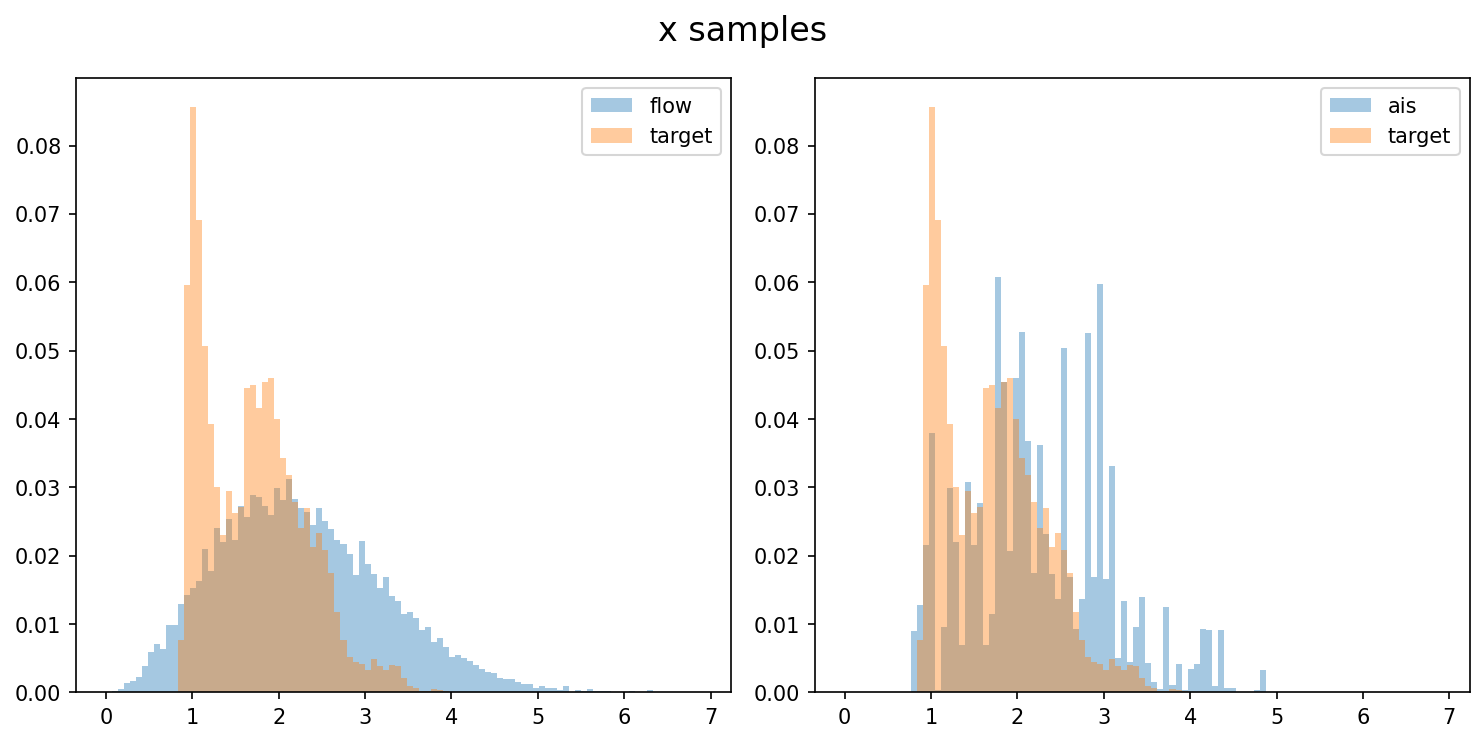

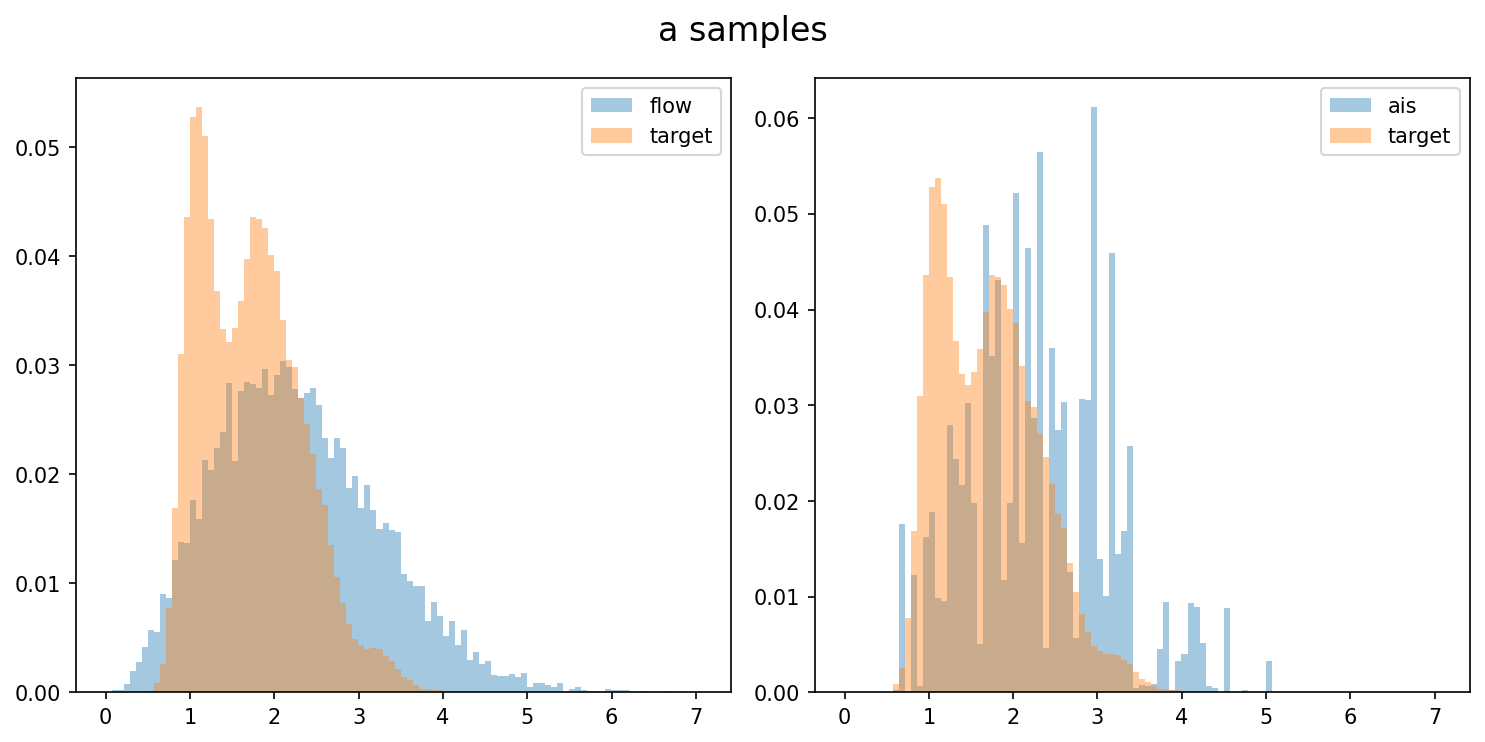

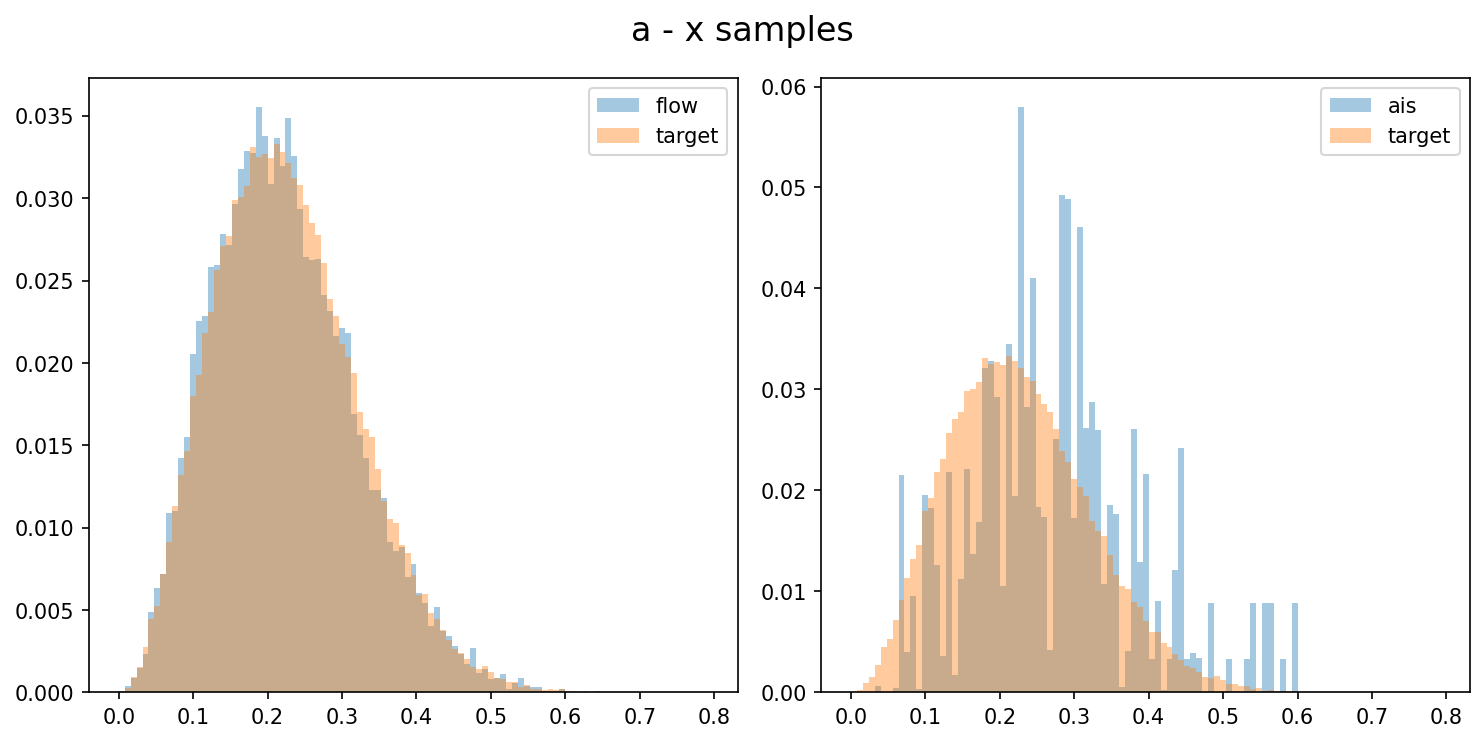

  0%|                                     | 1/4000 [14:15<950:17:53, 855.48s/it]

{'ess_marginal': Array(0.9999999, dtype=float32), 'eval_ess_ais': Array(0.00108097, dtype=float32), 'eval_ess_flow': Array(0.00108097, dtype=float32), 'eval_log_lik': Array(-8.44976, dtype=float32), 'latent_x_mean_abs_centre_of_mass': Array(7.489364e-09, dtype=float32), 'marginal_log_lik': Array(-42.97246, dtype=float32), 'max_abs_diff_log_det_forward_reverse': Array(4.567419e-05, dtype=float32), 'max_abs_diff_log_prob_after_group_action': Array(0.00131645, dtype=float32), 'mean_abs_diff_log_det_forward_reverse': Array(2.9041033e-05, dtype=float32), 'mean_abs_diff_log_prob_after_group_action': Array(0.00015173, dtype=float32), 'mean_abs_x_centre_of_mass': Array(1.2153257e-08, dtype=float32), 'mean_diff_samples_flow_inverse_forward': Array(1.681647e-06, dtype=float32), 'var_log_w': Array(4.3070177e-08, dtype=float32), 'iteration': 0}


 11%|████▍                                   | 444/4000 [19:02<38:33,  1.54it/s]

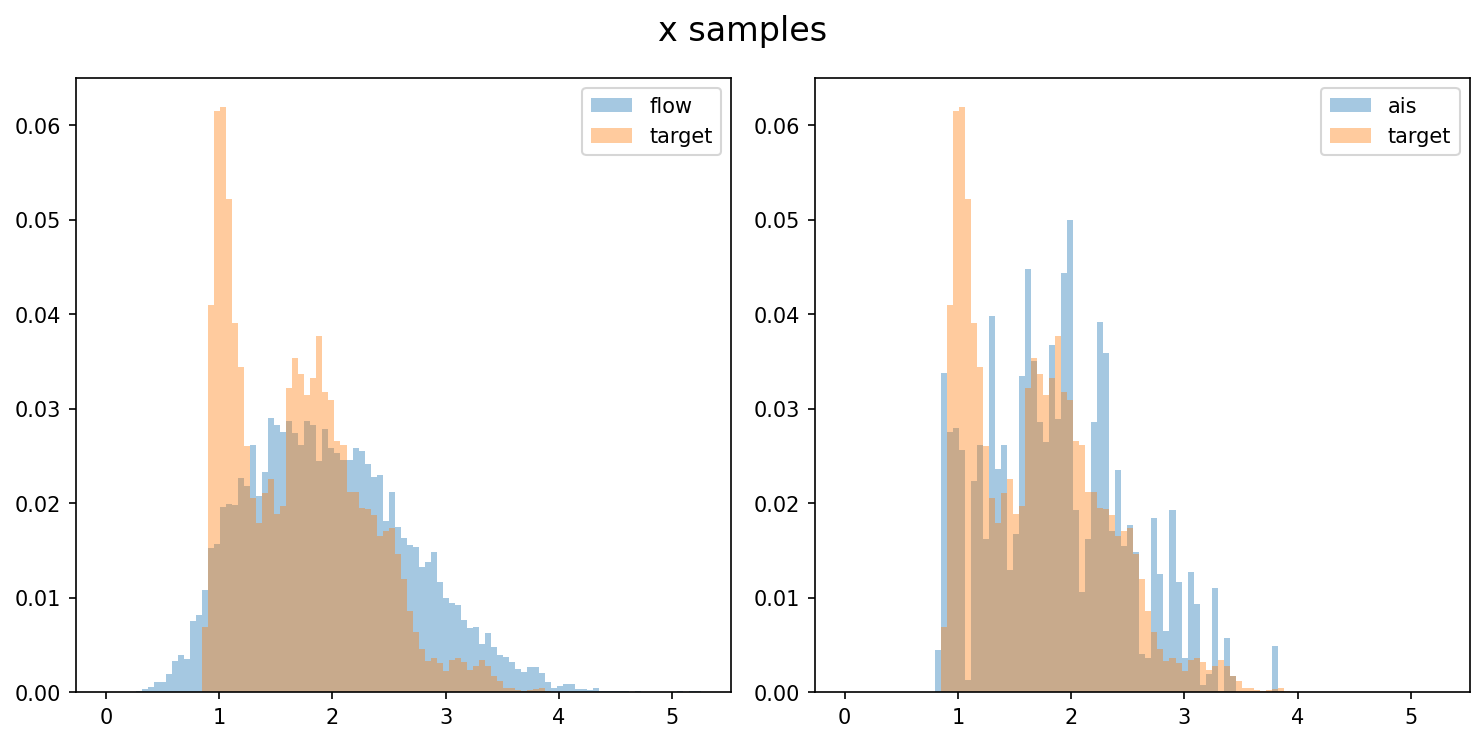

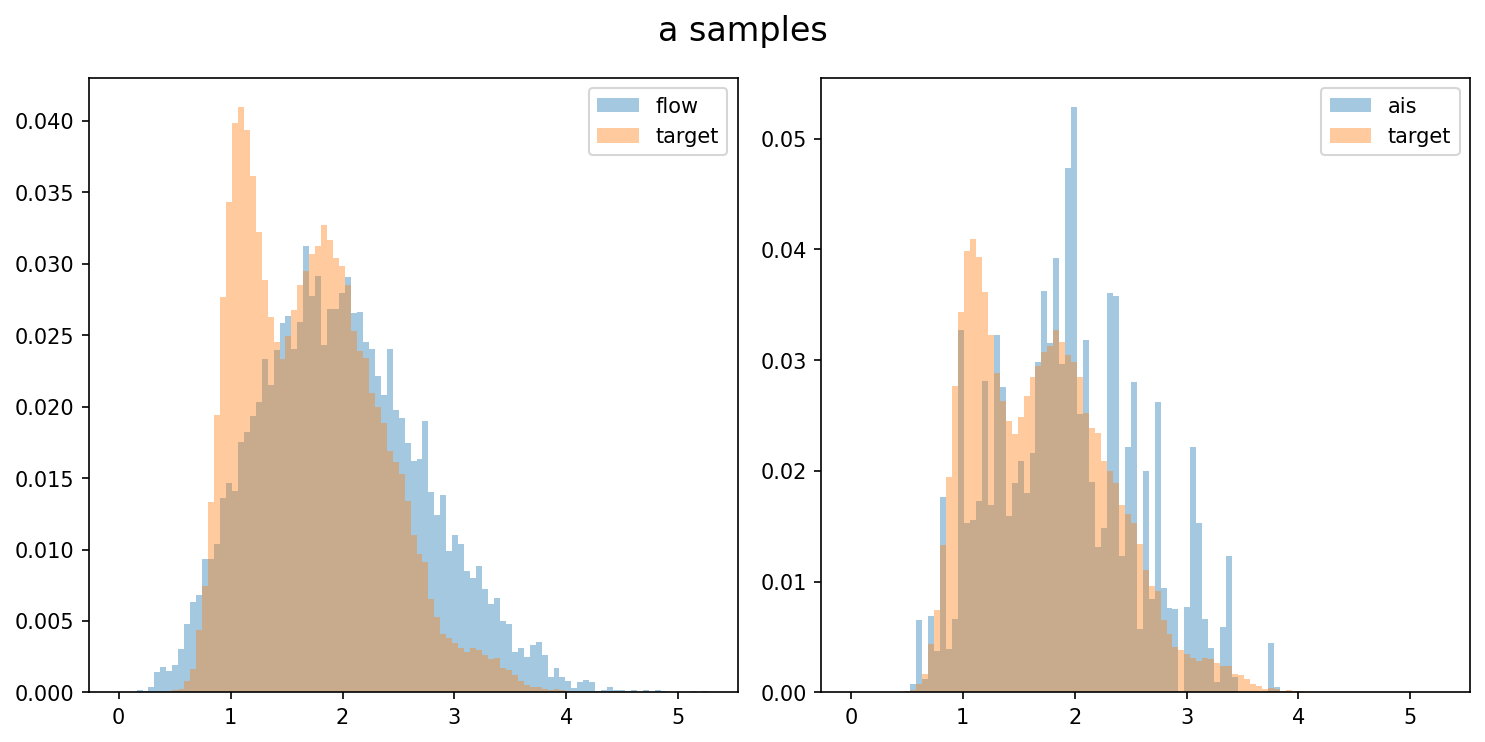

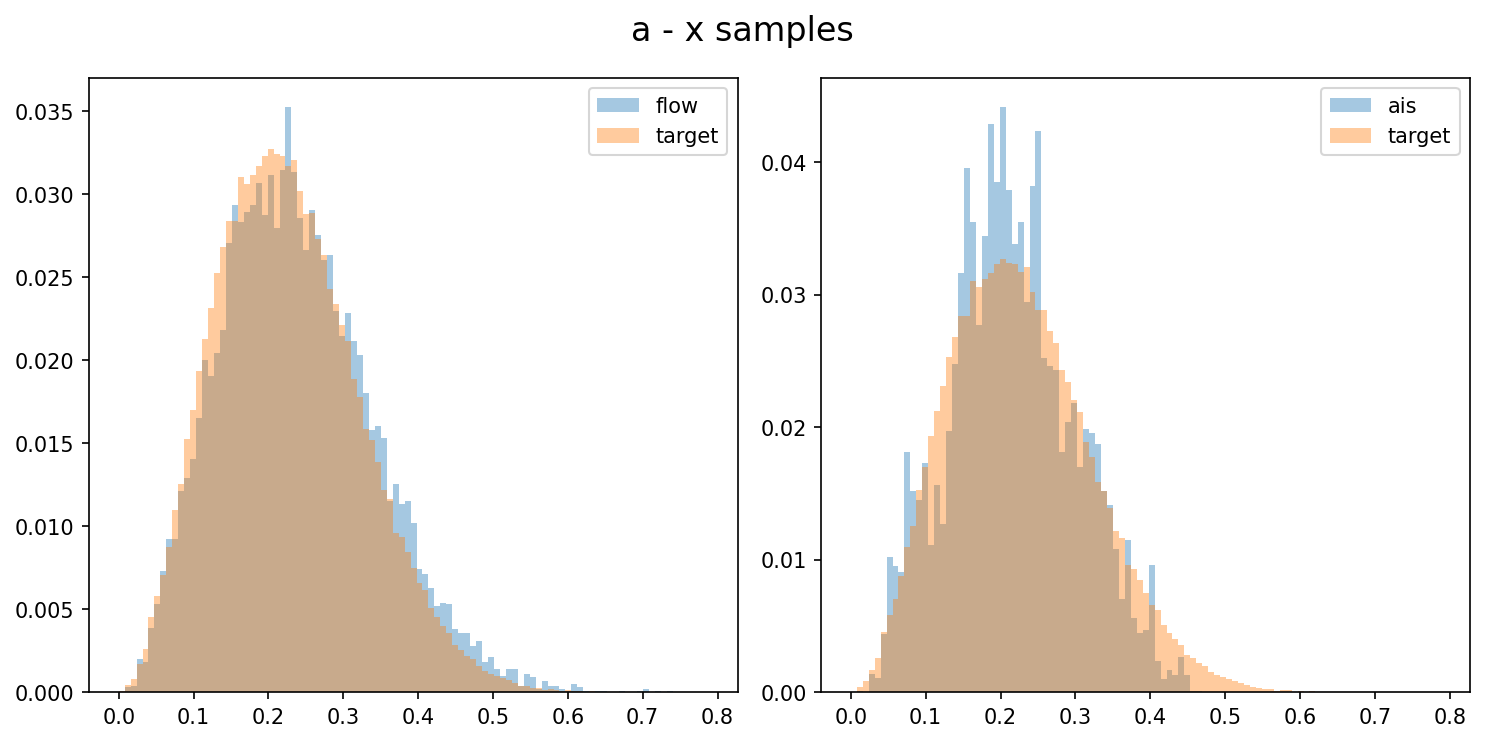

 11%|████▏                                 | 445/4000 [19:07<1:54:38,  1.93s/it]

{'ess_marginal': Array(0.07942158, dtype=float32), 'eval_ess_ais': Array(0.00166562, dtype=float32), 'eval_ess_flow': Array(0.00165926, dtype=float32), 'eval_log_lik': Array(-25.683523, dtype=float32), 'latent_x_mean_abs_centre_of_mass': Array(7.4431923e-09, dtype=float32), 'marginal_log_lik': Array(-48.0763, dtype=float32), 'max_abs_diff_log_det_forward_reverse': Array(0.0016581, dtype=float32), 'max_abs_diff_log_prob_after_group_action': Array(0.00174264, dtype=float32), 'mean_abs_diff_log_det_forward_reverse': Array(0.00019908, dtype=float32), 'mean_abs_diff_log_prob_after_group_action': Array(0.00022081, dtype=float32), 'mean_abs_x_centre_of_mass': Array(1.2071641e-08, dtype=float32), 'mean_diff_samples_flow_inverse_forward': Array(1.2105983e-06, dtype=float32), 'var_log_w': Array(83.40439, dtype=float32), 'iteration': 444}


 22%|████████▉                               | 888/4000 [23:58<33:57,  1.53it/s]

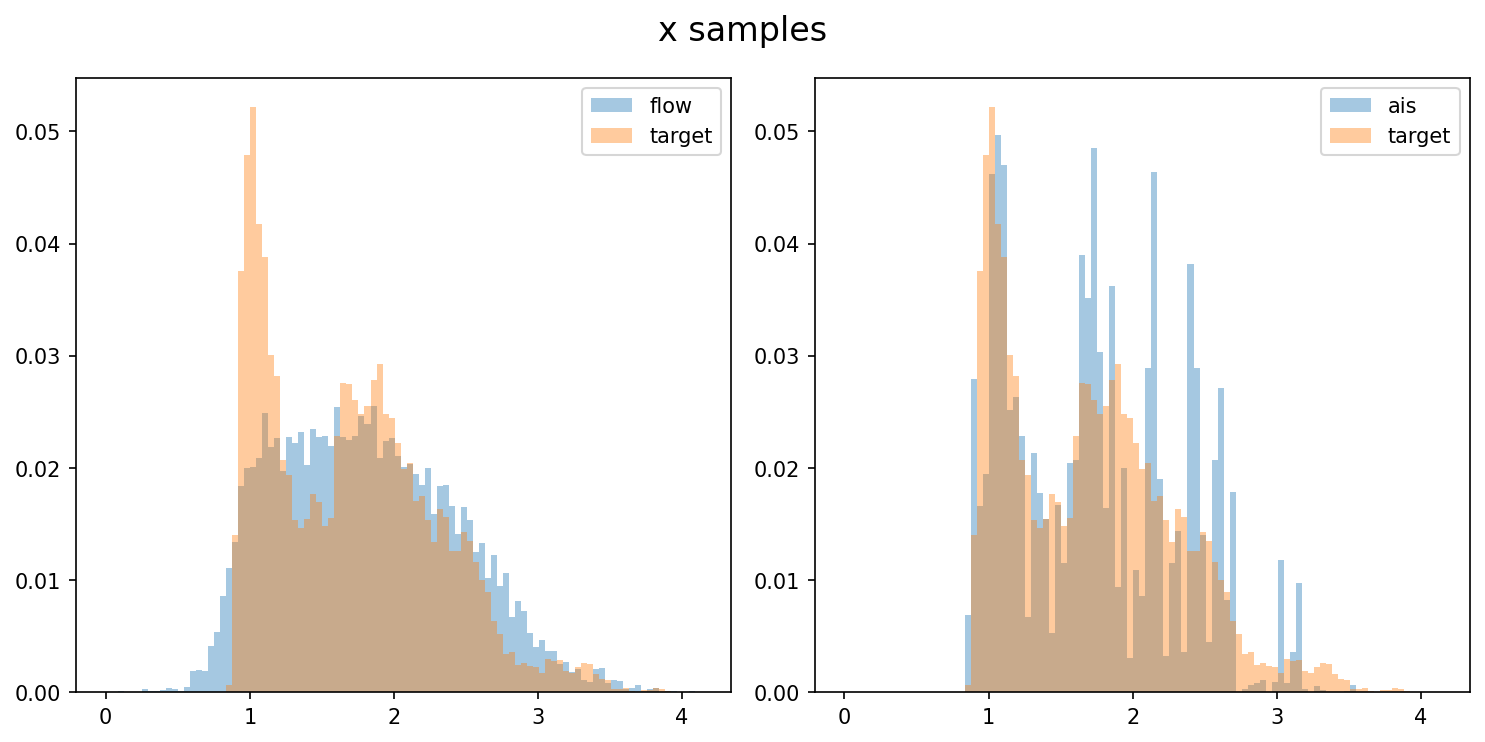

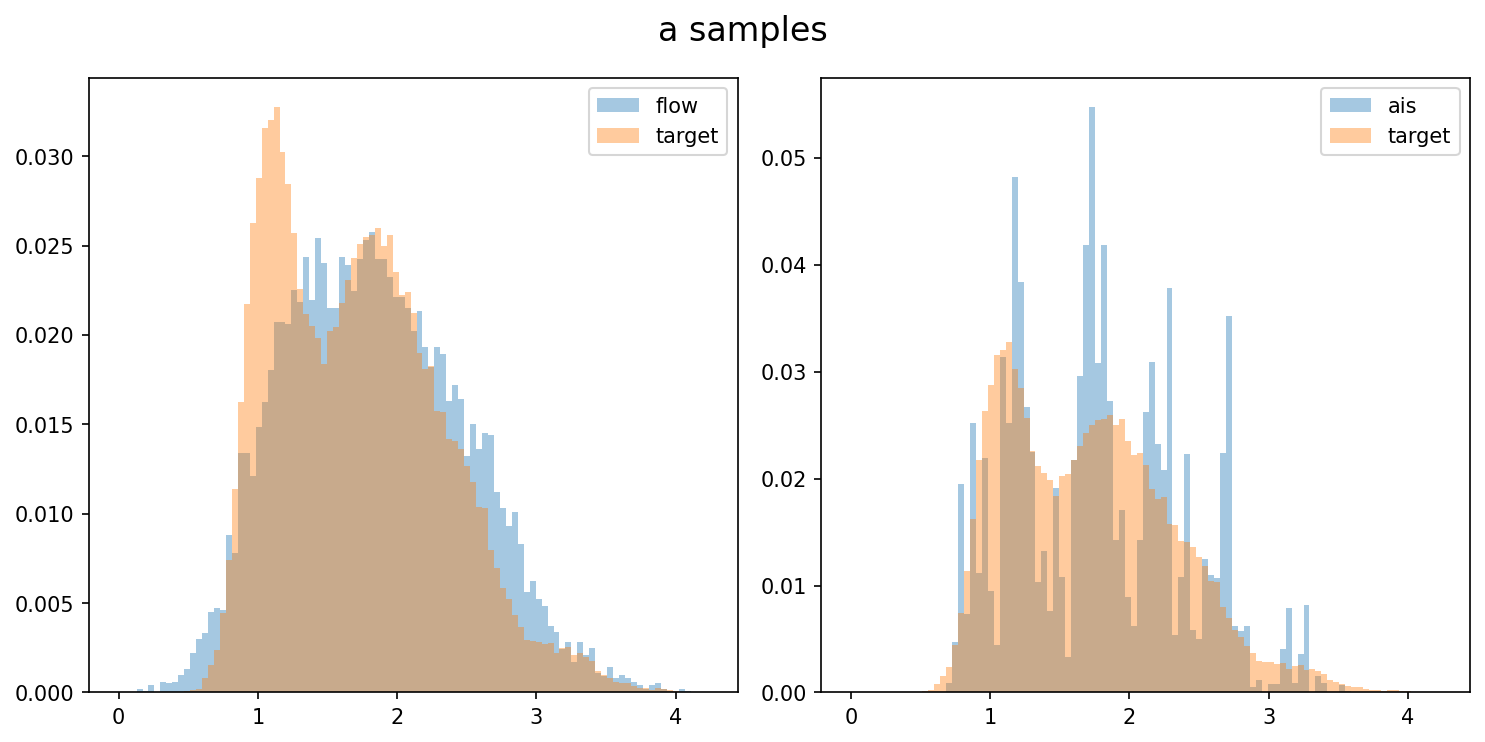

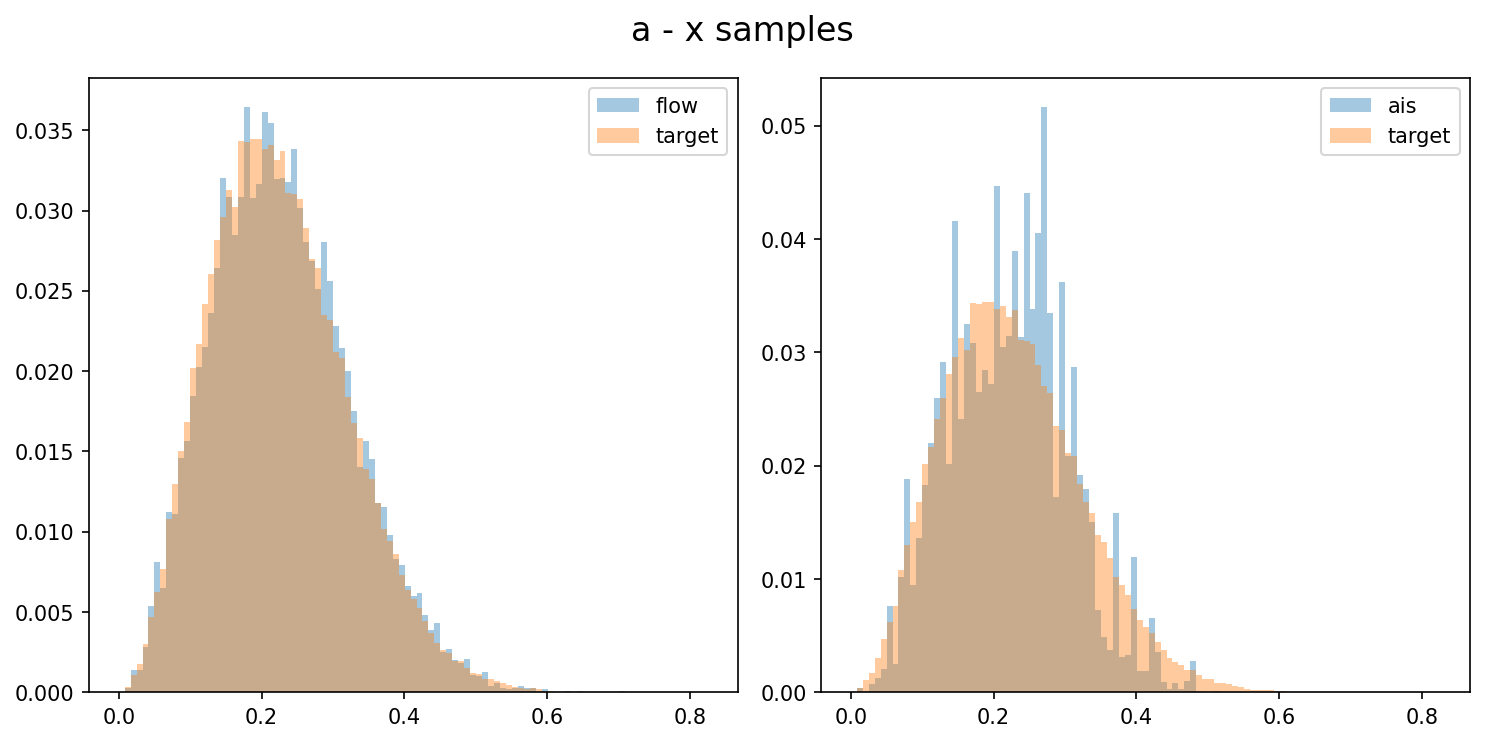

 22%|████████▍                             | 889/4000 [24:03<1:39:59,  1.93s/it]

{'ess_marginal': Array(0.08598471, dtype=float32), 'eval_ess_ais': Array(0.00116091, dtype=float32), 'eval_ess_flow': Array(0.00116217, dtype=float32), 'eval_log_lik': Array(-10.979001, dtype=float32), 'latent_x_mean_abs_centre_of_mass': Array(8.330559e-09, dtype=float32), 'marginal_log_lik': Array(-35.25407, dtype=float32), 'max_abs_diff_log_det_forward_reverse': Array(0.00230217, dtype=float32), 'max_abs_diff_log_prob_after_group_action': Array(0.00166593, dtype=float32), 'mean_abs_diff_log_det_forward_reverse': Array(0.00019955, dtype=float32), 'mean_abs_diff_log_prob_after_group_action': Array(0.00021852, dtype=float32), 'mean_abs_x_centre_of_mass': Array(1.0921967e-08, dtype=float32), 'mean_diff_samples_flow_inverse_forward': Array(1.2869842e-06, dtype=float32), 'var_log_w': Array(77.5709, dtype=float32), 'iteration': 888}


 33%|████████████▉                          | 1333/4000 [28:53<29:01,  1.53it/s]

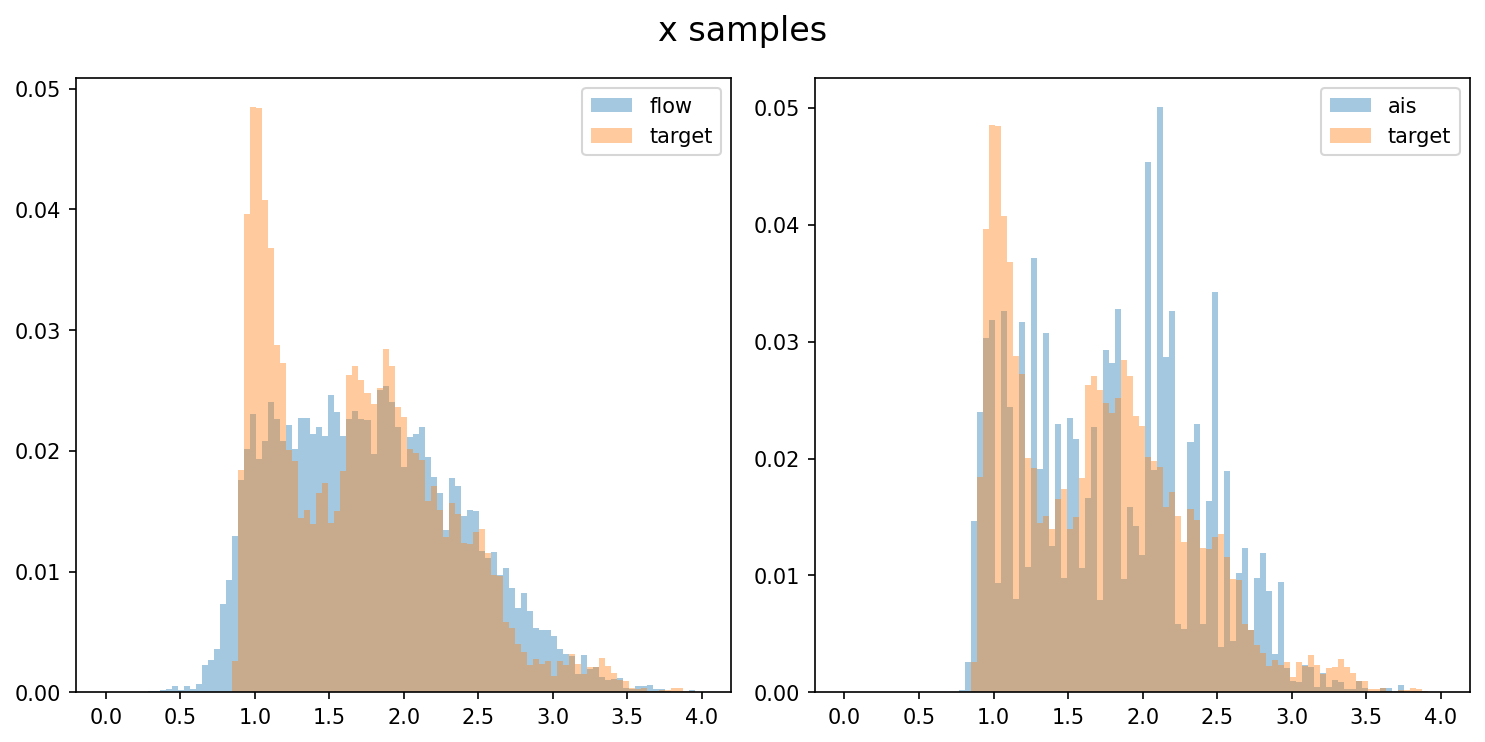

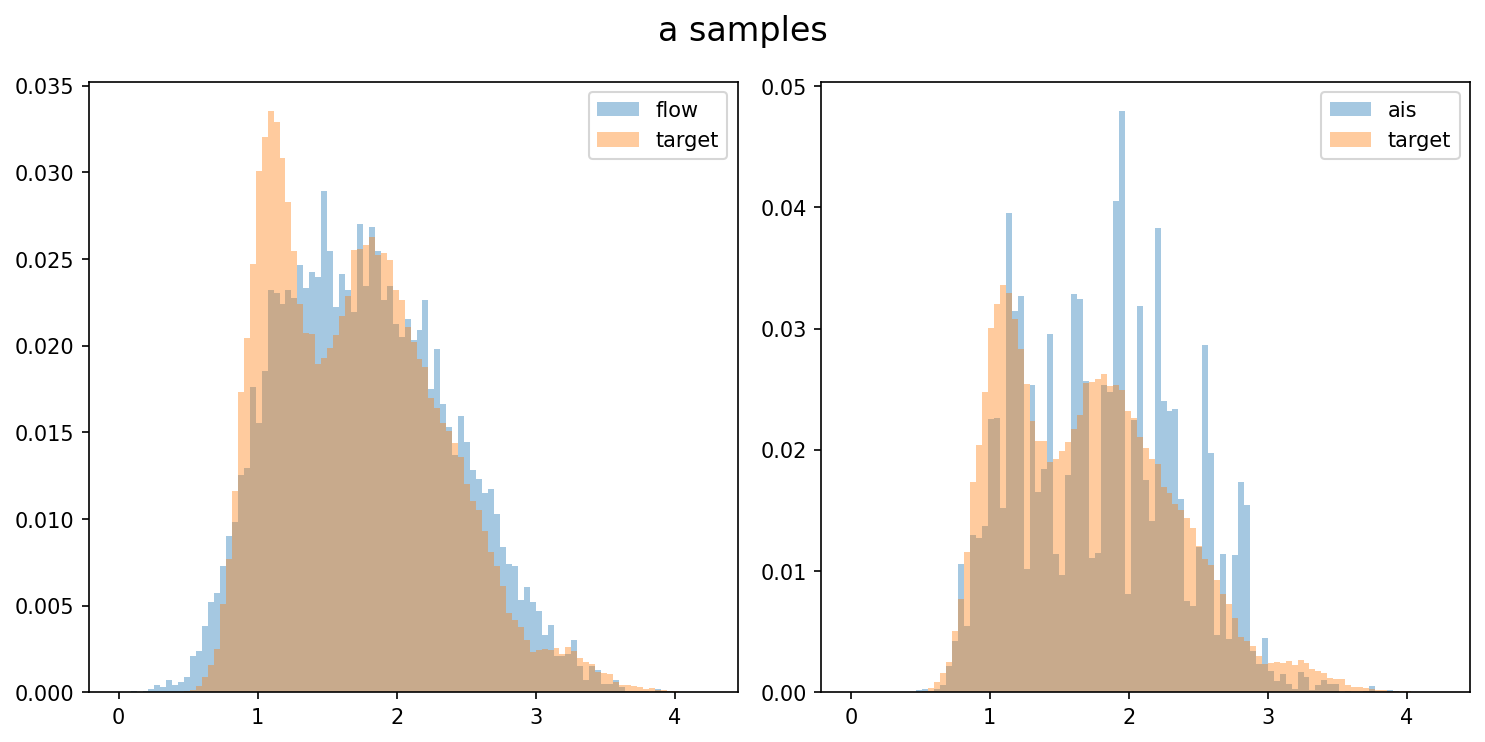

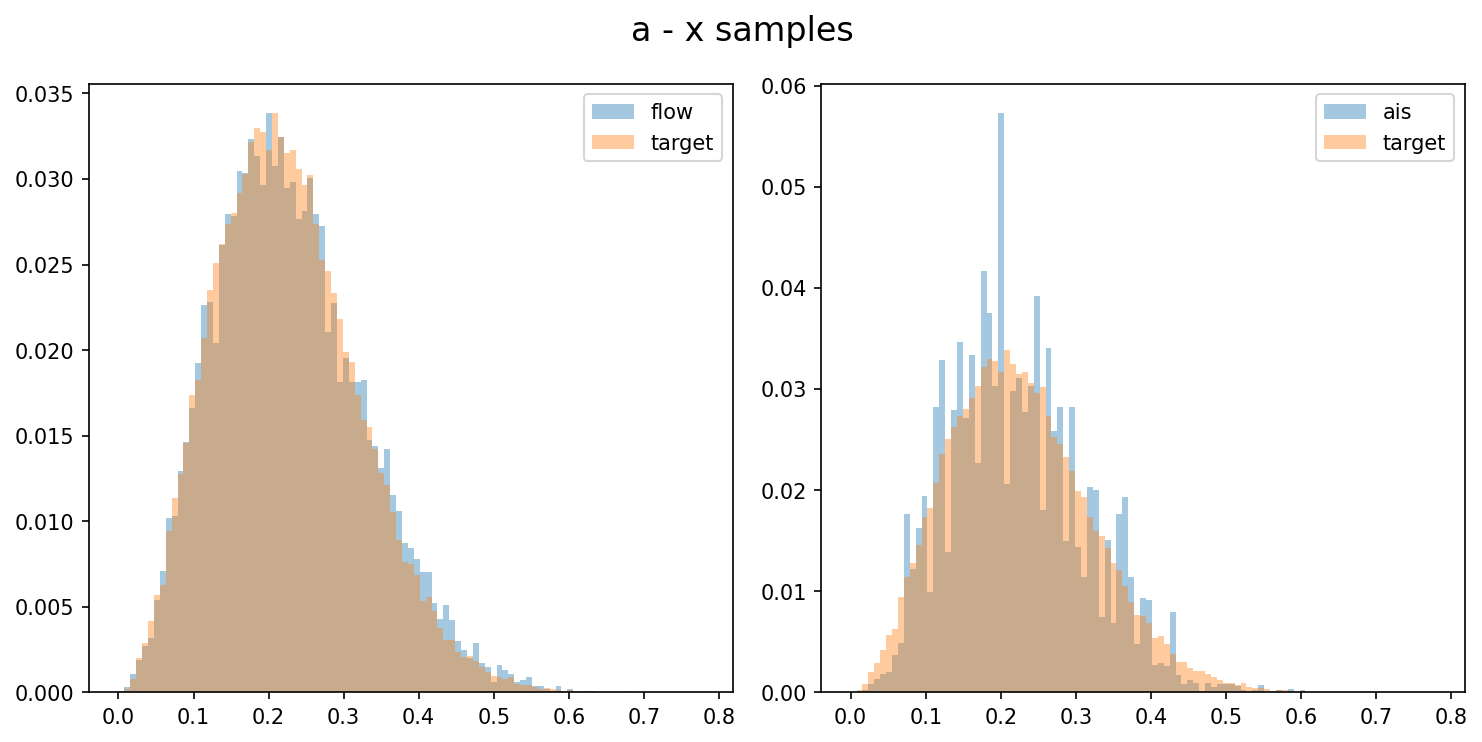

 33%|████████████▎                        | 1334/4000 [28:59<1:38:42,  2.22s/it]

{'ess_marginal': Array(0.09050252, dtype=float32), 'eval_ess_ais': Array(0.0023875, dtype=float32), 'eval_ess_flow': Array(0.00240522, dtype=float32), 'eval_log_lik': Array(-8.72882, dtype=float32), 'latent_x_mean_abs_centre_of_mass': Array(8.994396e-09, dtype=float32), 'marginal_log_lik': Array(-34.041405, dtype=float32), 'max_abs_diff_log_det_forward_reverse': Array(0.0032662, dtype=float32), 'max_abs_diff_log_prob_after_group_action': Array(0.00138228, dtype=float32), 'mean_abs_diff_log_det_forward_reverse': Array(0.0001716, dtype=float32), 'mean_abs_diff_log_prob_after_group_action': Array(0.00018144, dtype=float32), 'mean_abs_x_centre_of_mass': Array(1.08149685e-08, dtype=float32), 'mean_diff_samples_flow_inverse_forward': Array(1.187336e-06, dtype=float32), 'var_log_w': Array(59.677536, dtype=float32), 'iteration': 1333}


 44%|█████████████████▎                     | 1777/4000 [33:48<24:05,  1.54it/s]

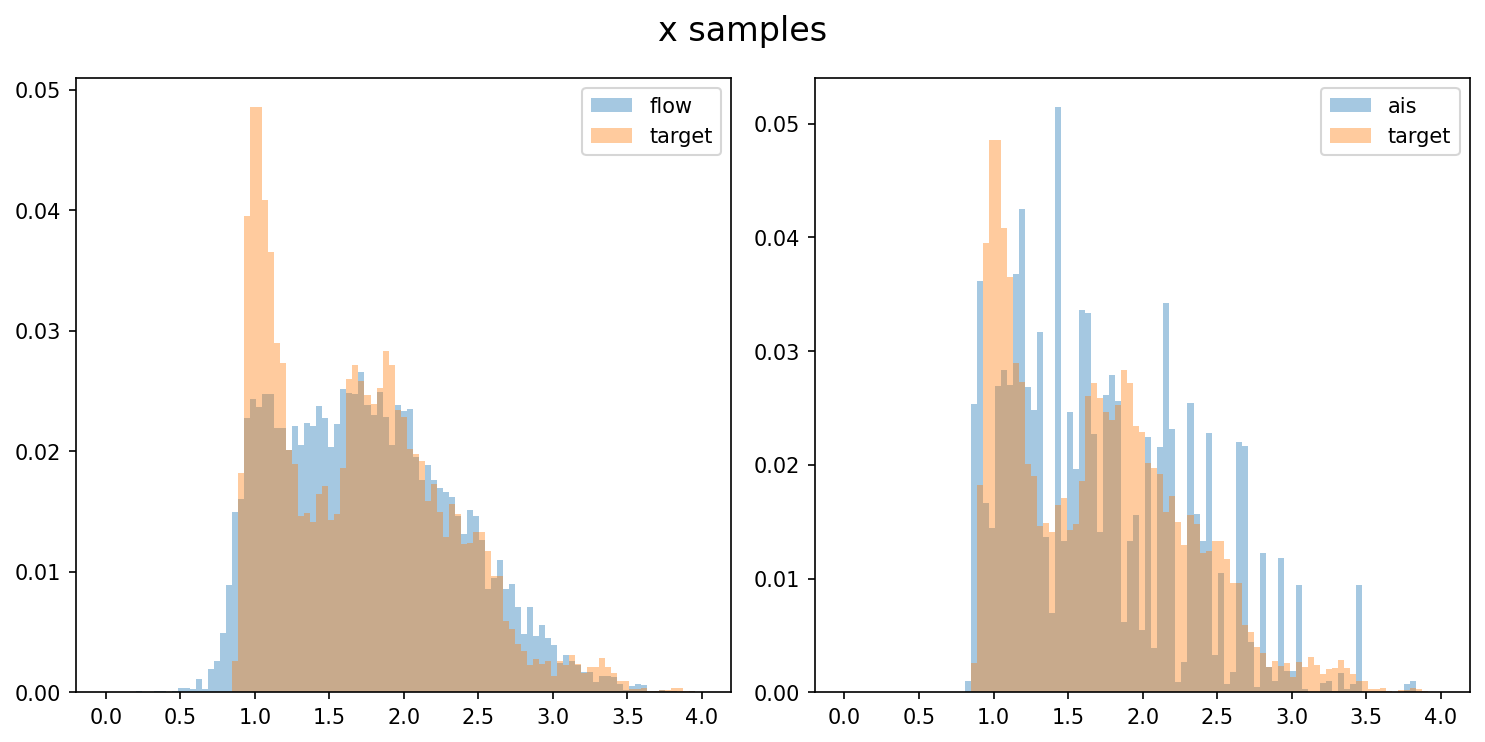

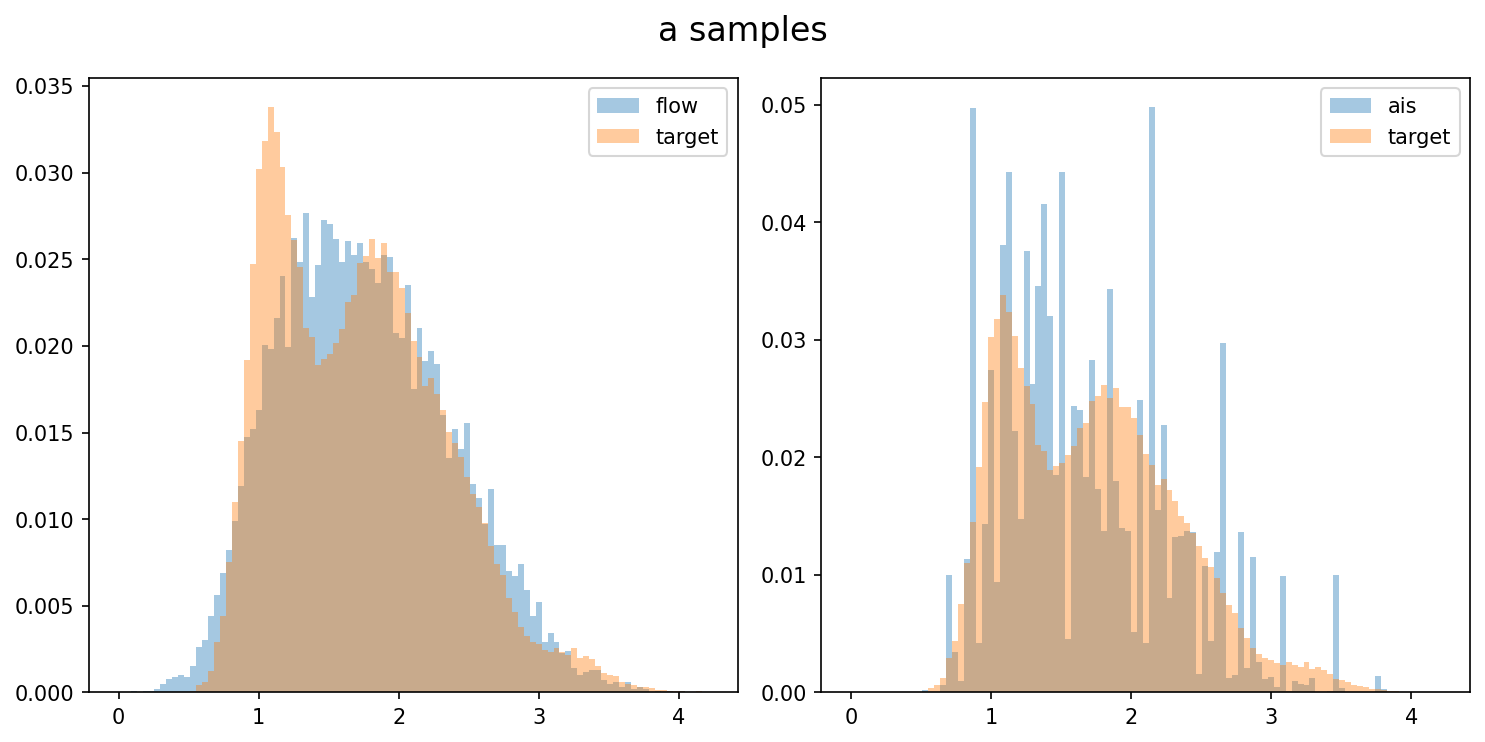

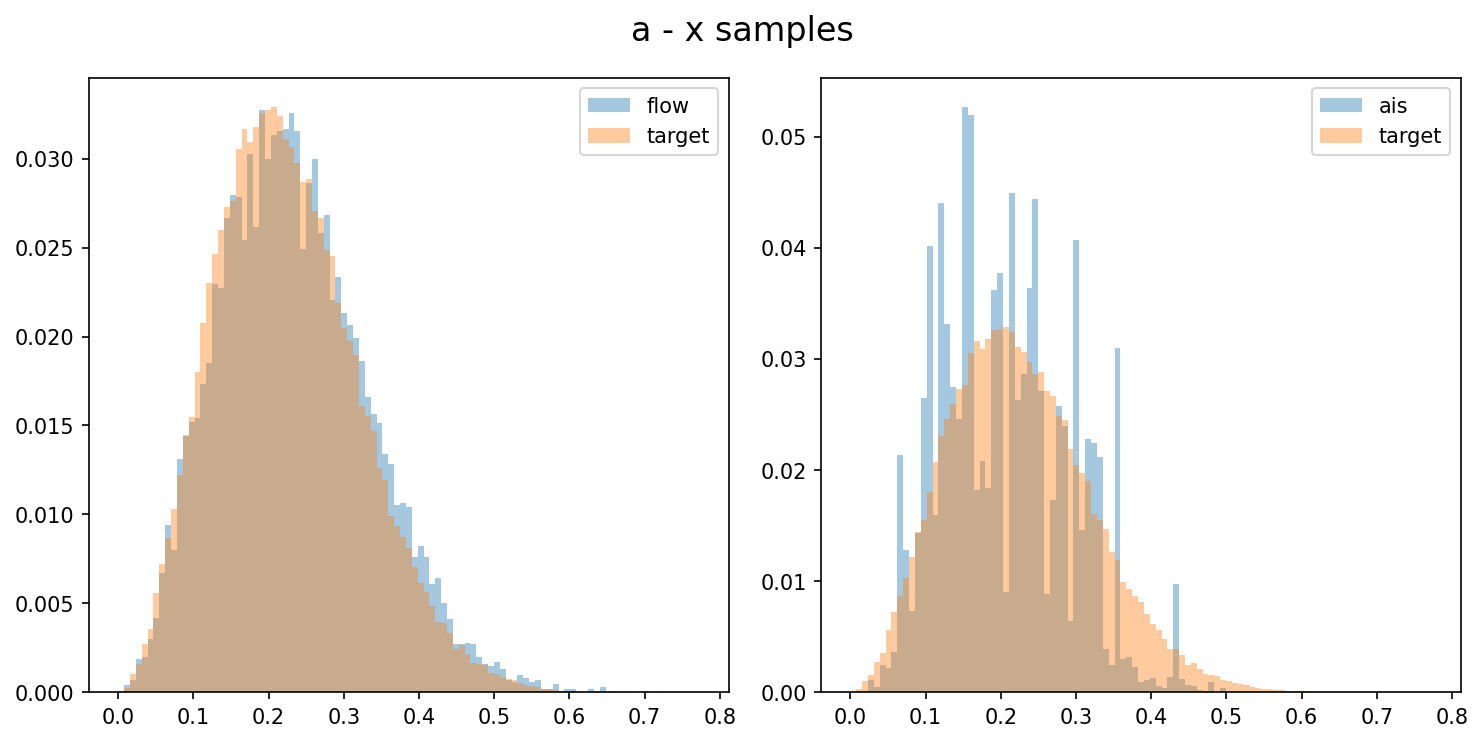

 44%|████████████████▍                    | 1778/4000 [33:53<1:11:48,  1.94s/it]

{'ess_marginal': Array(0.09299124, dtype=float32), 'eval_ess_ais': Array(0.00115849, dtype=float32), 'eval_ess_flow': Array(0.0011583, dtype=float32), 'eval_log_lik': Array(-6.7200685, dtype=float32), 'latent_x_mean_abs_centre_of_mass': Array(9.05629e-09, dtype=float32), 'marginal_log_lik': Array(-32.349743, dtype=float32), 'max_abs_diff_log_det_forward_reverse': Array(0.0015395, dtype=float32), 'max_abs_diff_log_prob_after_group_action': Array(0.00219727, dtype=float32), 'mean_abs_diff_log_det_forward_reverse': Array(0.00015218, dtype=float32), 'mean_abs_diff_log_prob_after_group_action': Array(0.00019397, dtype=float32), 'mean_abs_x_centre_of_mass': Array(1.0628525e-08, dtype=float32), 'mean_diff_samples_flow_inverse_forward': Array(1.0708267e-06, dtype=float32), 'var_log_w': Array(56.872955, dtype=float32), 'iteration': 1777}


 56%|█████████████████████▋                 | 2221/4000 [38:42<19:17,  1.54it/s]

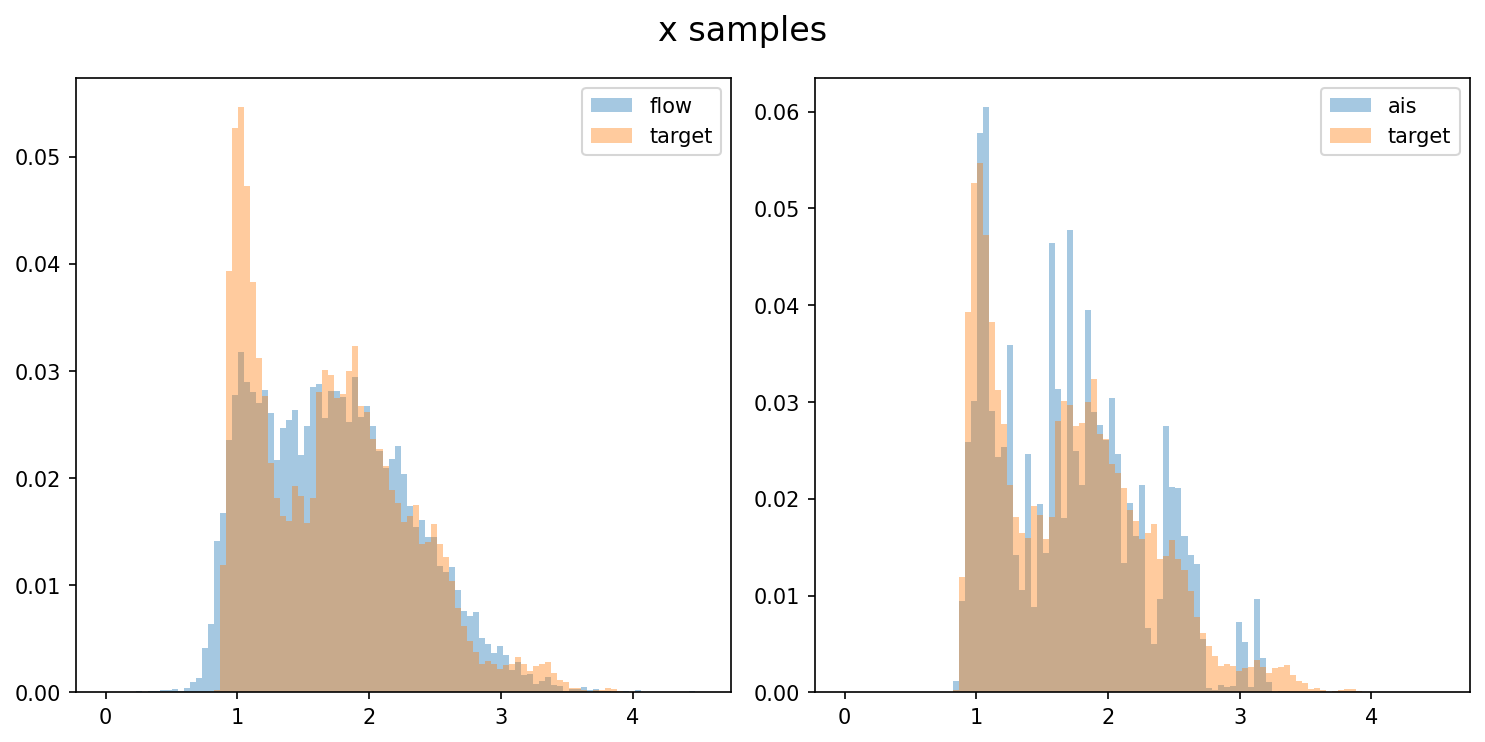

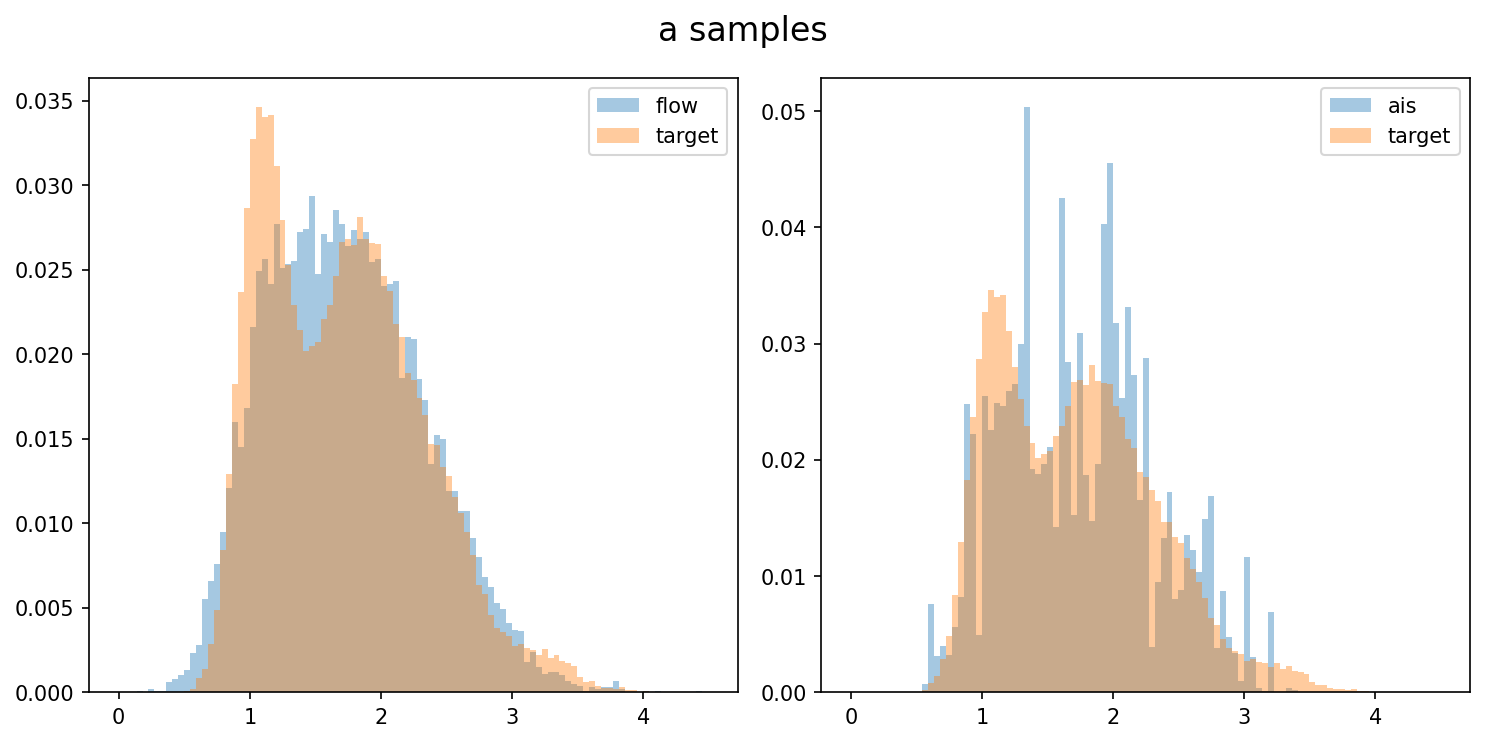

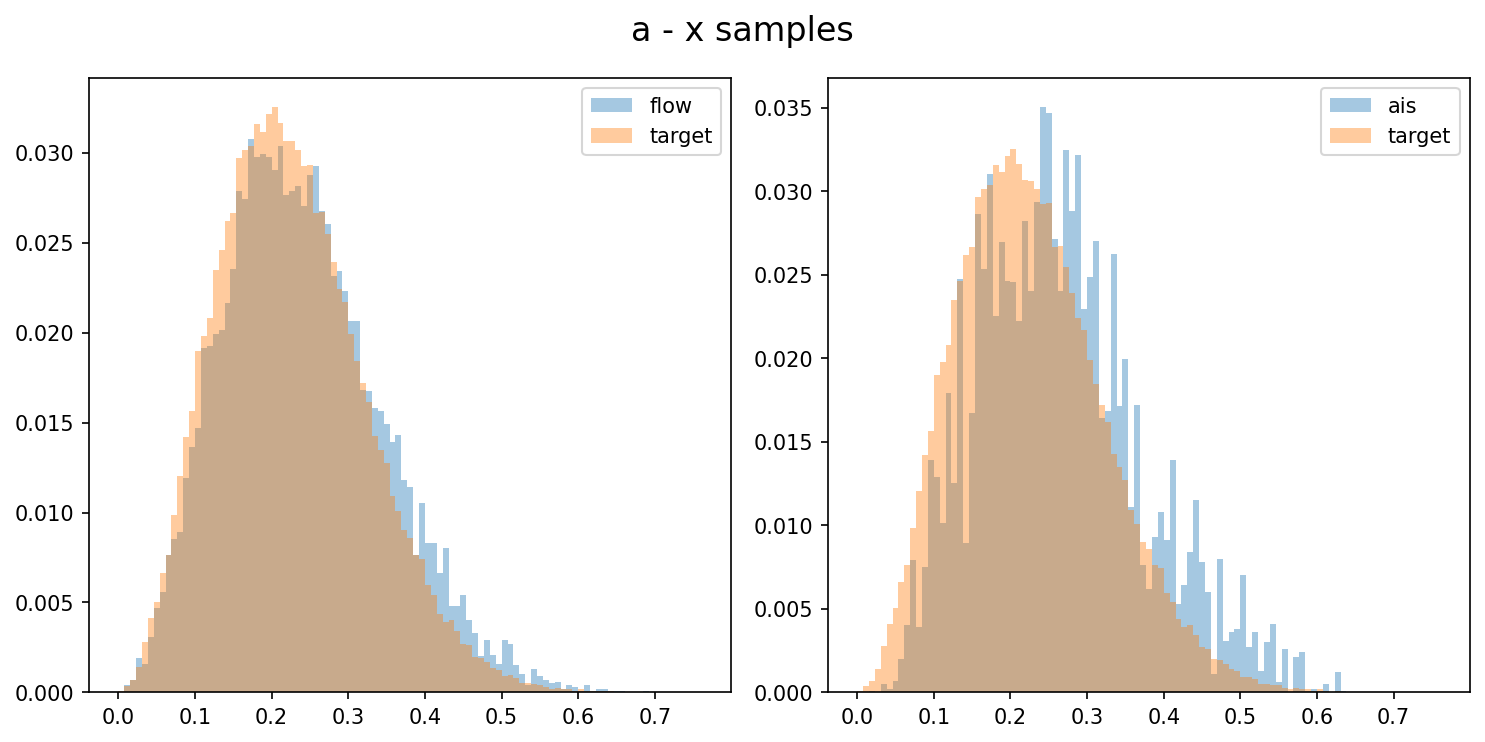

 56%|█████████████████████▋                 | 2222/4000 [38:47<57:08,  1.93s/it]

{'ess_marginal': Array(0.09522977, dtype=float32), 'eval_ess_ais': Array(0.00110029, dtype=float32), 'eval_ess_flow': Array(0.00110513, dtype=float32), 'eval_log_lik': Array(-5.336705, dtype=float32), 'latent_x_mean_abs_centre_of_mass': Array(9.117403e-09, dtype=float32), 'marginal_log_lik': Array(-31.955835, dtype=float32), 'max_abs_diff_log_det_forward_reverse': Array(0.00165095, dtype=float32), 'max_abs_diff_log_prob_after_group_action': Array(0.00320462, dtype=float32), 'mean_abs_diff_log_det_forward_reverse': Array(0.00015996, dtype=float32), 'mean_abs_diff_log_prob_after_group_action': Array(0.00018719, dtype=float32), 'mean_abs_x_centre_of_mass': Array(1.0399244e-08, dtype=float32), 'mean_diff_samples_flow_inverse_forward': Array(1.1862164e-06, dtype=float32), 'var_log_w': Array(41.5456, dtype=float32), 'iteration': 2221}


 67%|█████████████████████████▉             | 2666/4000 [43:36<14:30,  1.53it/s]

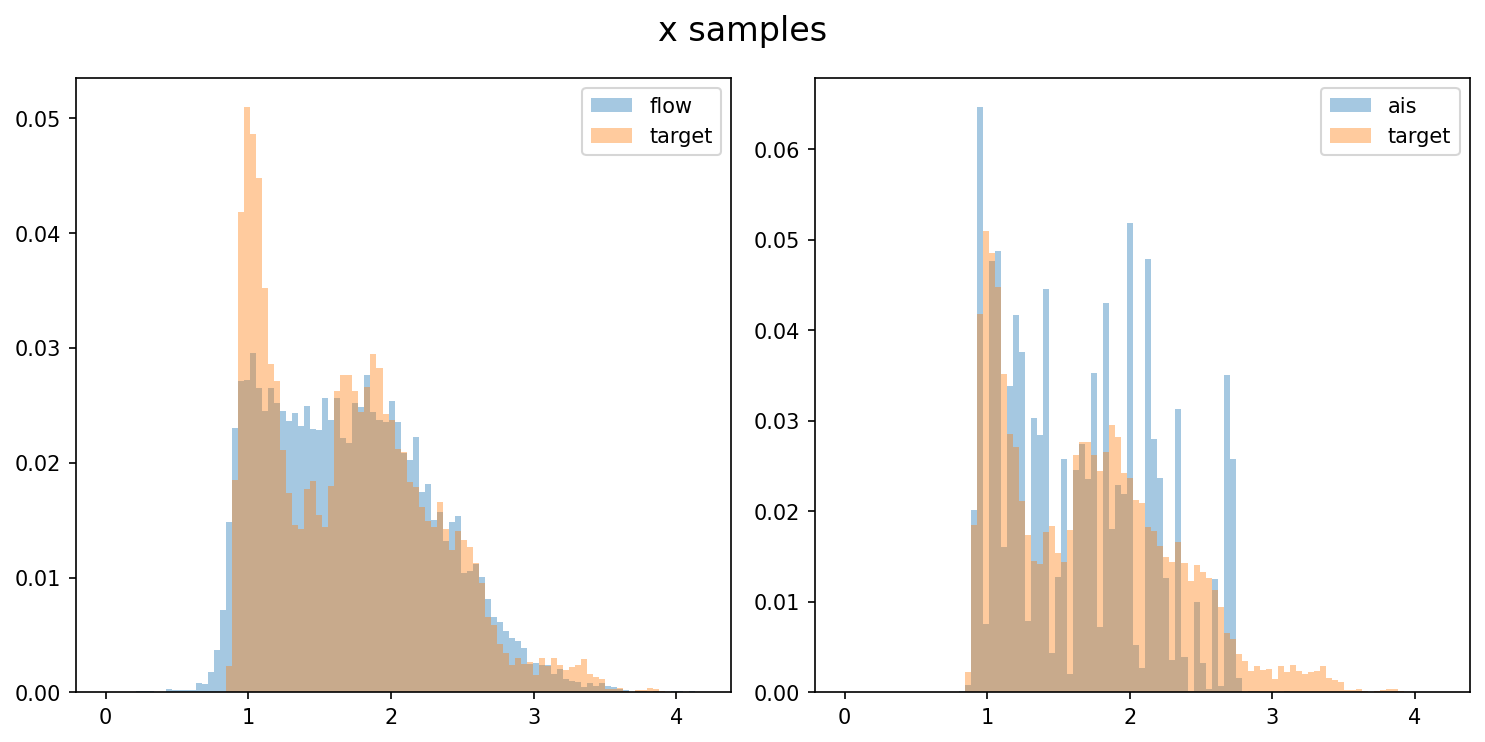

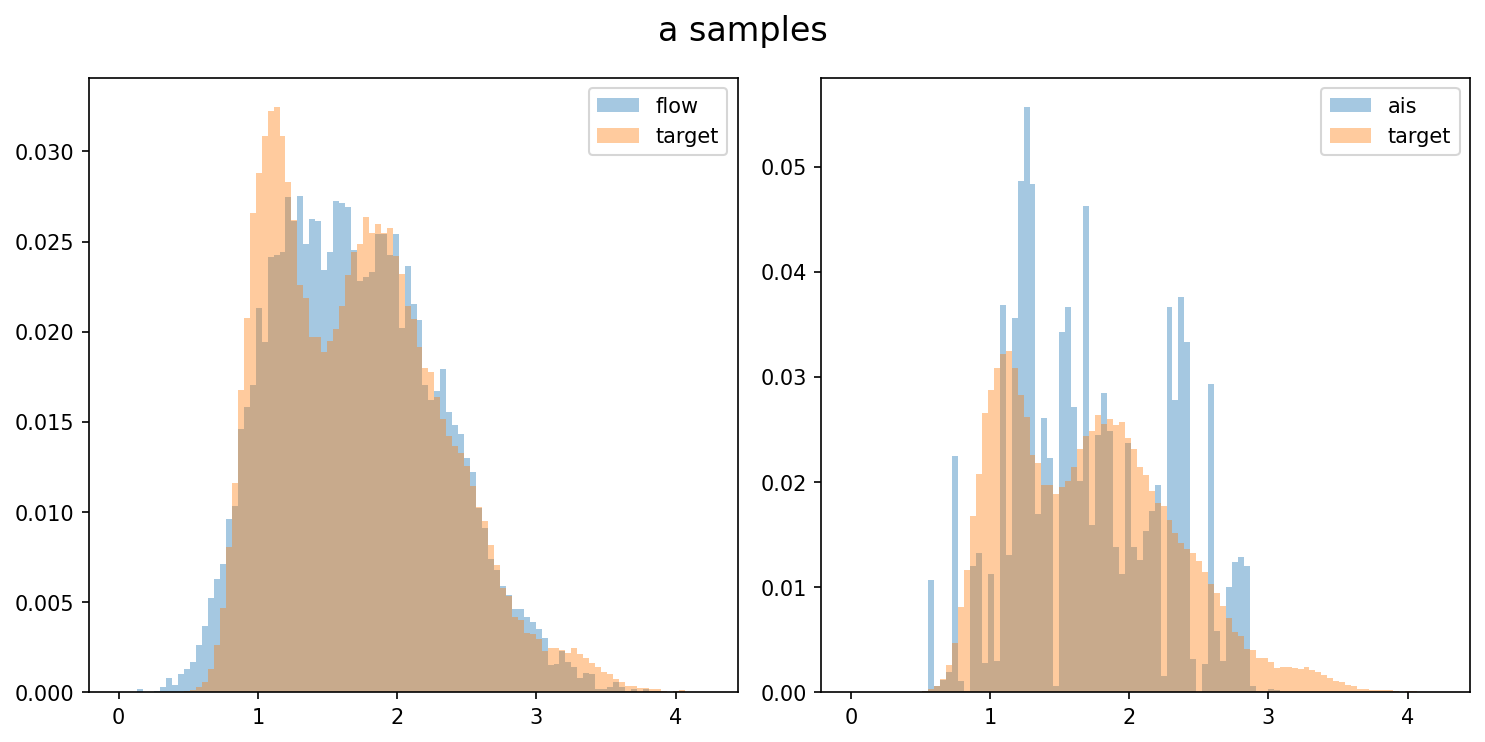

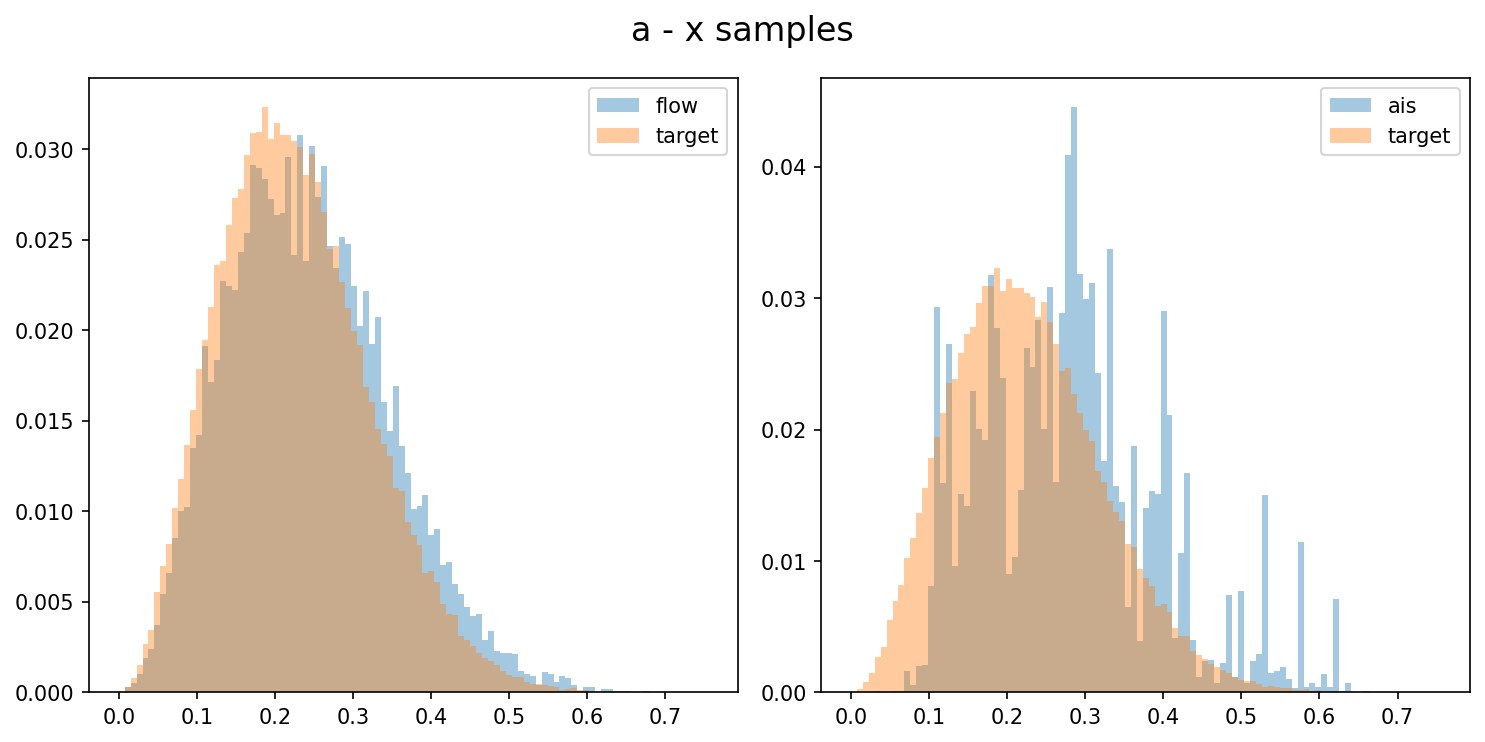

 67%|██████████████████████████             | 2667/4000 [43:41<42:50,  1.93s/it]

{'ess_marginal': Array(0.10523184, dtype=float32), 'eval_ess_ais': Array(0.00361798, dtype=float32), 'eval_ess_flow': Array(0.00365534, dtype=float32), 'eval_log_lik': Array(-2.7755978, dtype=float32), 'latent_x_mean_abs_centre_of_mass': Array(9.361448e-09, dtype=float32), 'marginal_log_lik': Array(-30.573154, dtype=float32), 'max_abs_diff_log_det_forward_reverse': Array(0.00126593, dtype=float32), 'max_abs_diff_log_prob_after_group_action': Array(0.00367083, dtype=float32), 'mean_abs_diff_log_det_forward_reverse': Array(0.00014606, dtype=float32), 'mean_abs_diff_log_prob_after_group_action': Array(0.00020171, dtype=float32), 'mean_abs_x_centre_of_mass': Array(1.026209e-08, dtype=float32), 'mean_diff_samples_flow_inverse_forward': Array(1.1036939e-06, dtype=float32), 'var_log_w': Array(33.067978, dtype=float32), 'iteration': 2666}


 78%|██████████████████████████████▎        | 3110/4000 [48:30<09:39,  1.54it/s]

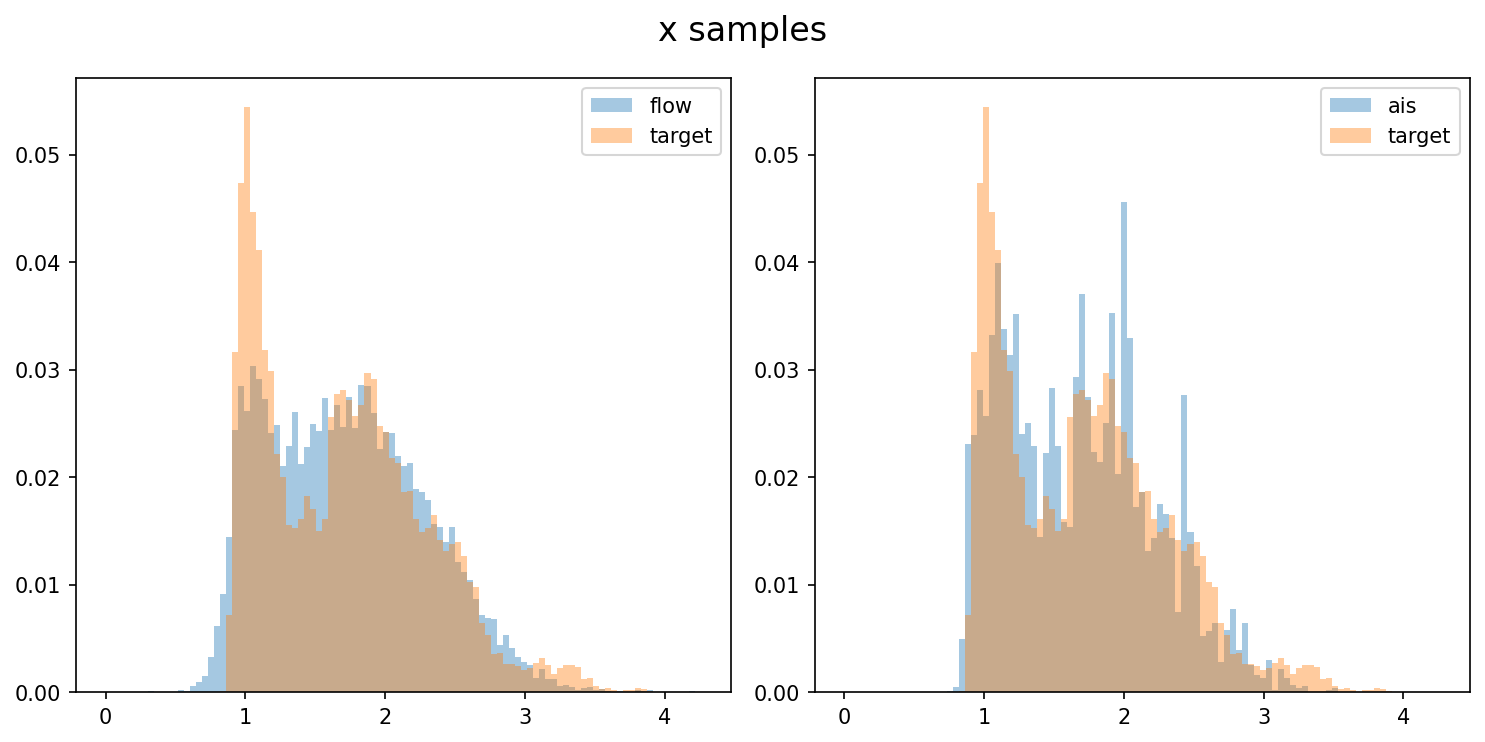

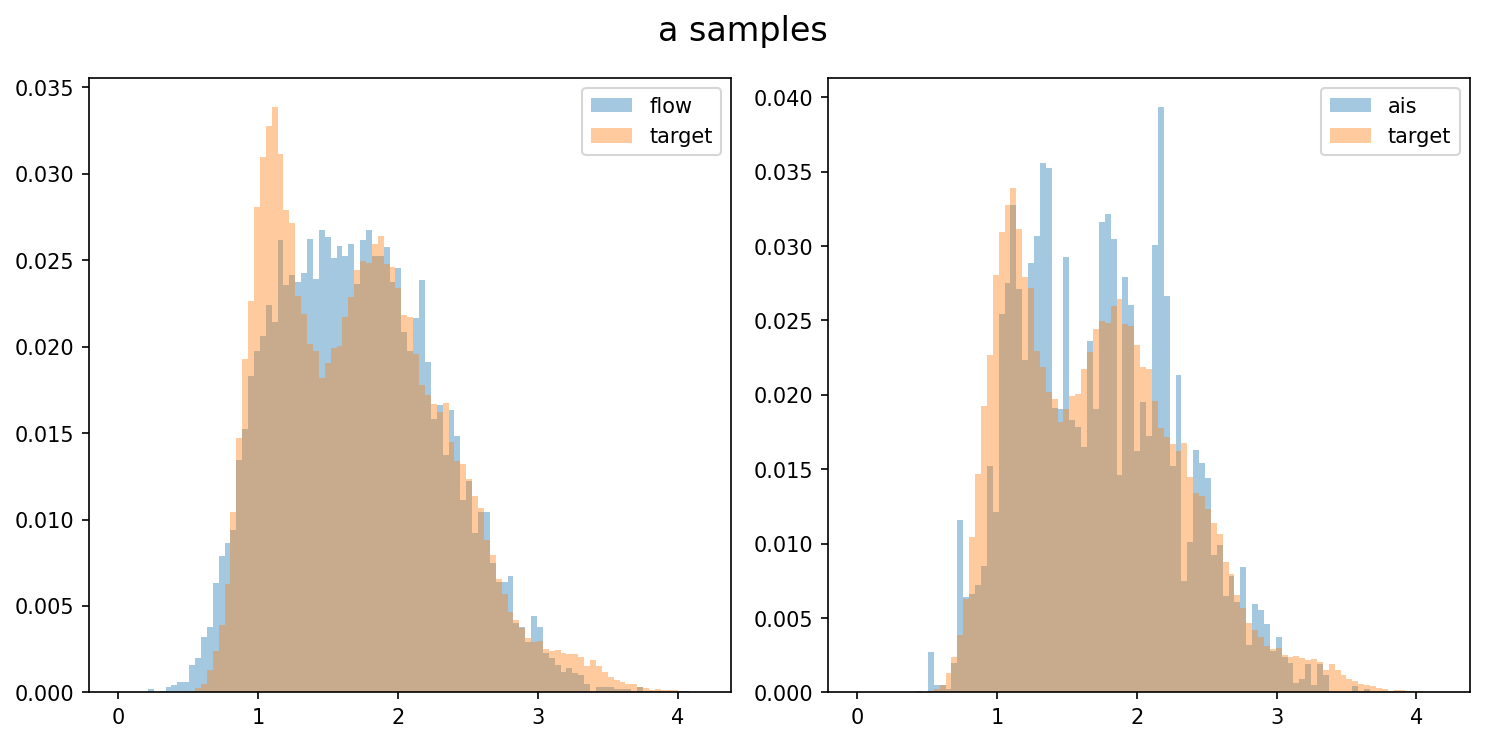

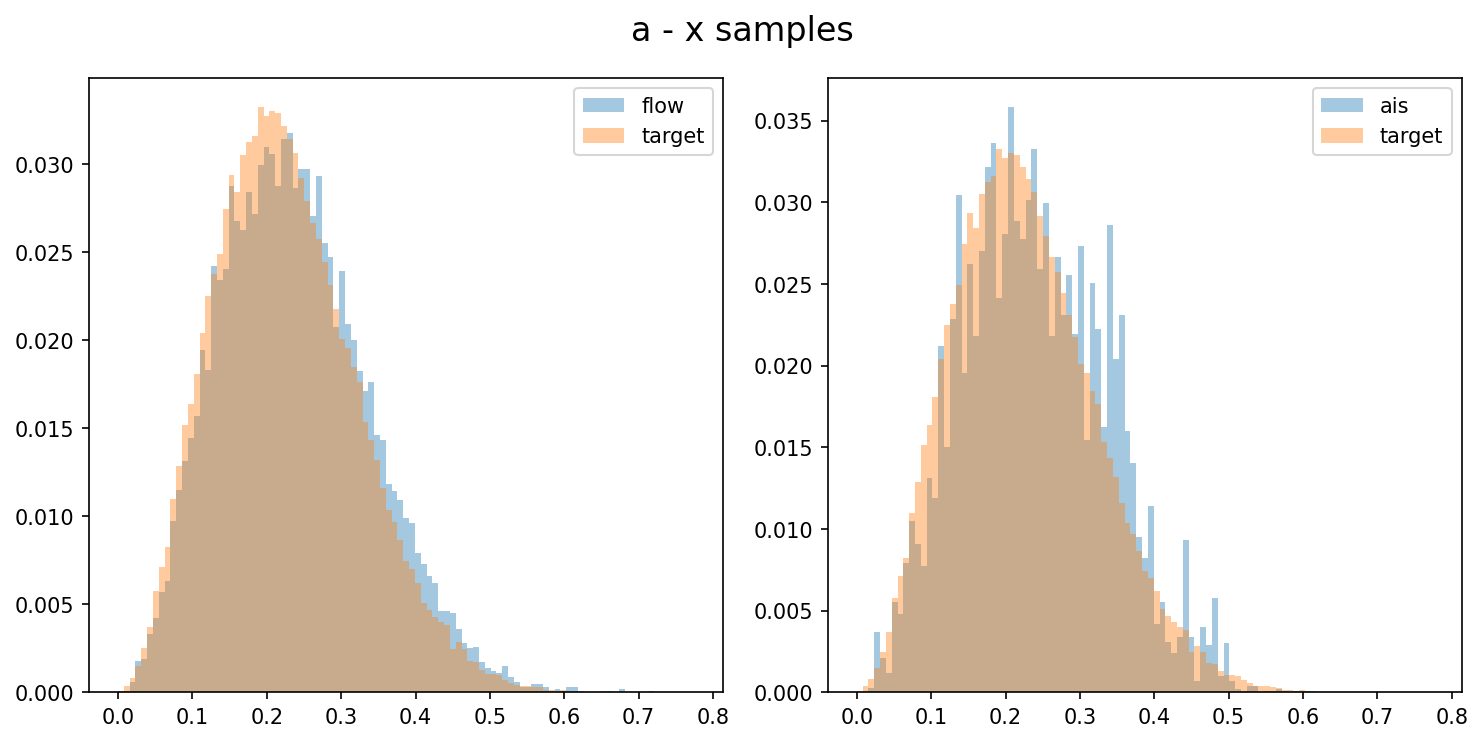

 78%|██████████████████████████████▎        | 3111/4000 [48:35<28:41,  1.94s/it]

{'ess_marginal': Array(0.10232125, dtype=float32), 'eval_ess_ais': Array(0.00229095, dtype=float32), 'eval_ess_flow': Array(0.00219807, dtype=float32), 'eval_log_lik': Array(-3.1120183, dtype=float32), 'latent_x_mean_abs_centre_of_mass': Array(9.819877e-09, dtype=float32), 'marginal_log_lik': Array(-30.716755, dtype=float32), 'max_abs_diff_log_det_forward_reverse': Array(0.00099891, dtype=float32), 'max_abs_diff_log_prob_after_group_action': Array(0.0029632, dtype=float32), 'mean_abs_diff_log_det_forward_reverse': Array(0.00014356, dtype=float32), 'mean_abs_diff_log_prob_after_group_action': Array(0.00017903, dtype=float32), 'mean_abs_x_centre_of_mass': Array(1.0217861e-08, dtype=float32), 'mean_diff_samples_flow_inverse_forward': Array(1.1616188e-06, dtype=float32), 'var_log_w': Array(34.241463, dtype=float32), 'iteration': 3110}


 89%|██████████████████████████████████▋    | 3554/4000 [53:25<04:50,  1.54it/s]

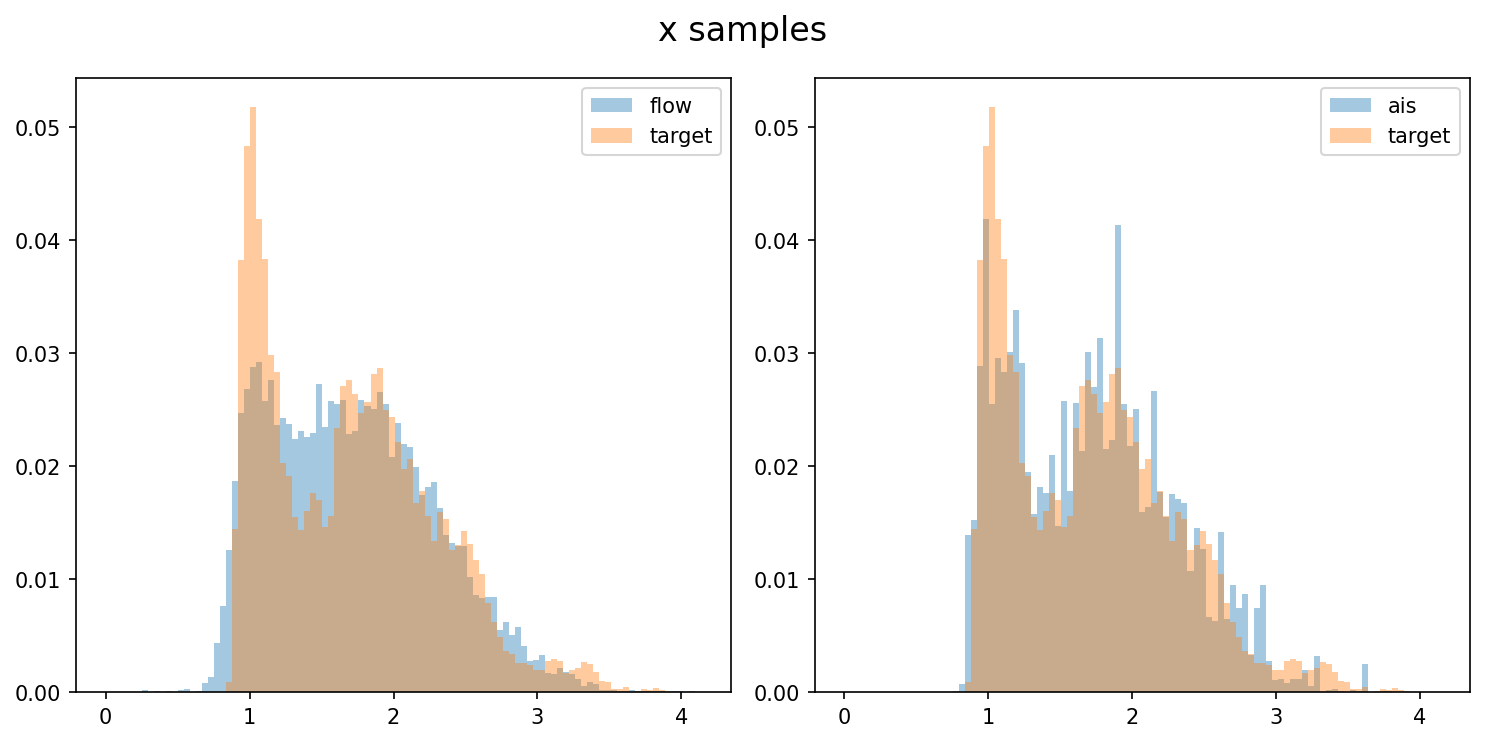

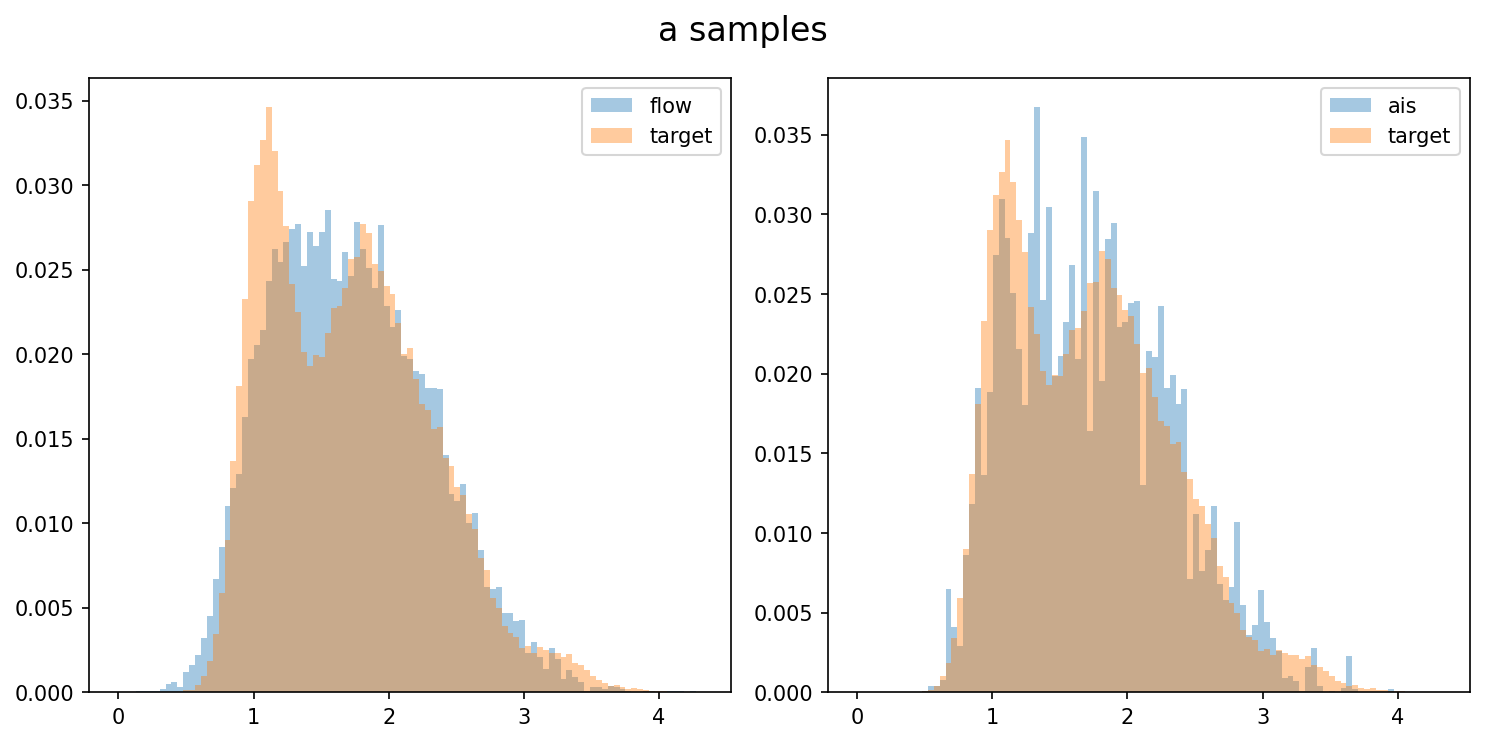

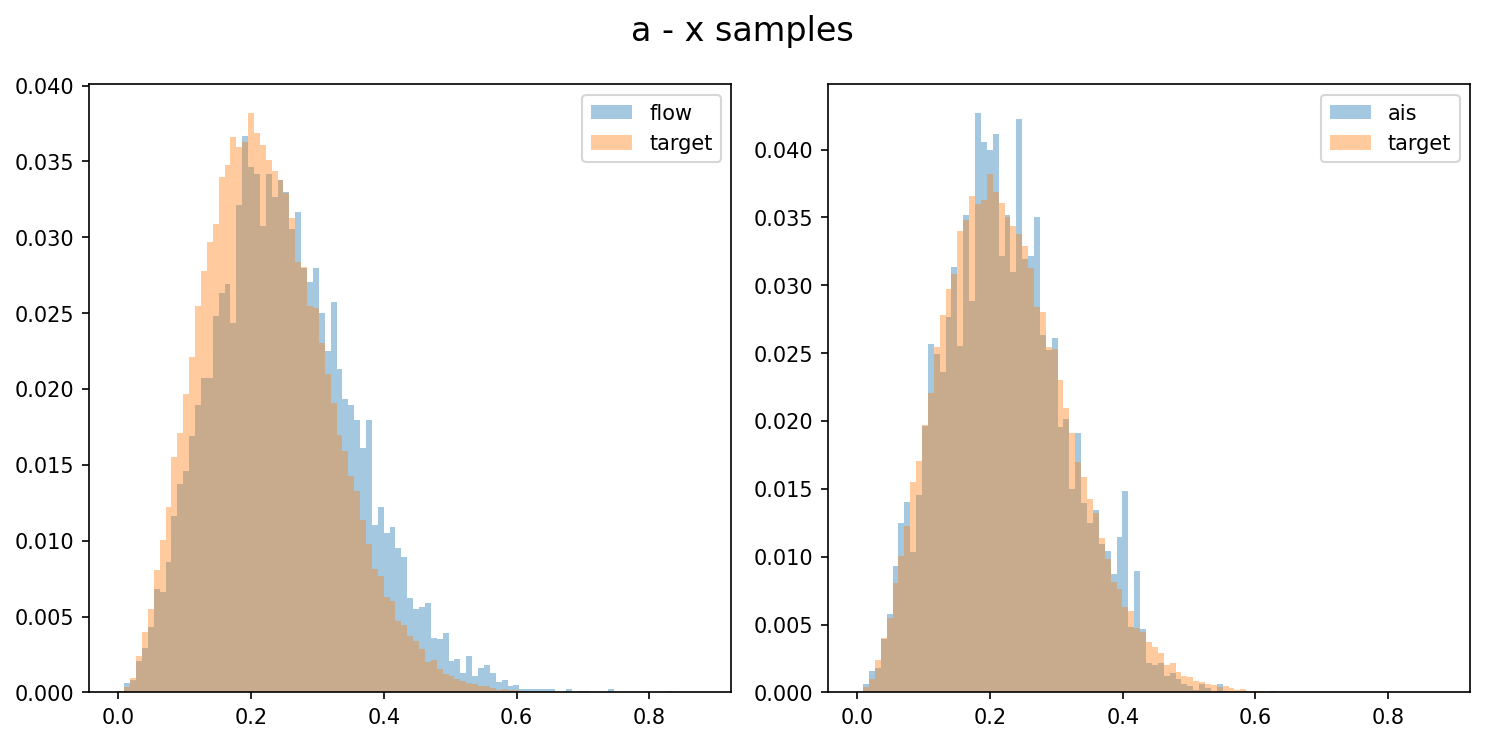

 89%|██████████████████████████████████▋    | 3555/4000 [53:29<14:17,  1.93s/it]

{'ess_marginal': Array(0.10558558, dtype=float32), 'eval_ess_ais': Array(0.00233039, dtype=float32), 'eval_ess_flow': Array(0.0028901, dtype=float32), 'eval_log_lik': Array(-2.2726018, dtype=float32), 'latent_x_mean_abs_centre_of_mass': Array(9.5427e-09, dtype=float32), 'marginal_log_lik': Array(-30.23667, dtype=float32), 'max_abs_diff_log_det_forward_reverse': Array(0.00135204, dtype=float32), 'max_abs_diff_log_prob_after_group_action': Array(0.00146839, dtype=float32), 'mean_abs_diff_log_det_forward_reverse': Array(0.00014907, dtype=float32), 'mean_abs_diff_log_prob_after_group_action': Array(0.00015752, dtype=float32), 'mean_abs_x_centre_of_mass': Array(1.0161589e-08, dtype=float32), 'mean_diff_samples_flow_inverse_forward': Array(1.0519178e-06, dtype=float32), 'var_log_w': Array(32.950638, dtype=float32), 'iteration': 3554}


100%|██████████████████████████████████████▉| 3999/4000 [58:20<00:00,  1.53it/s]

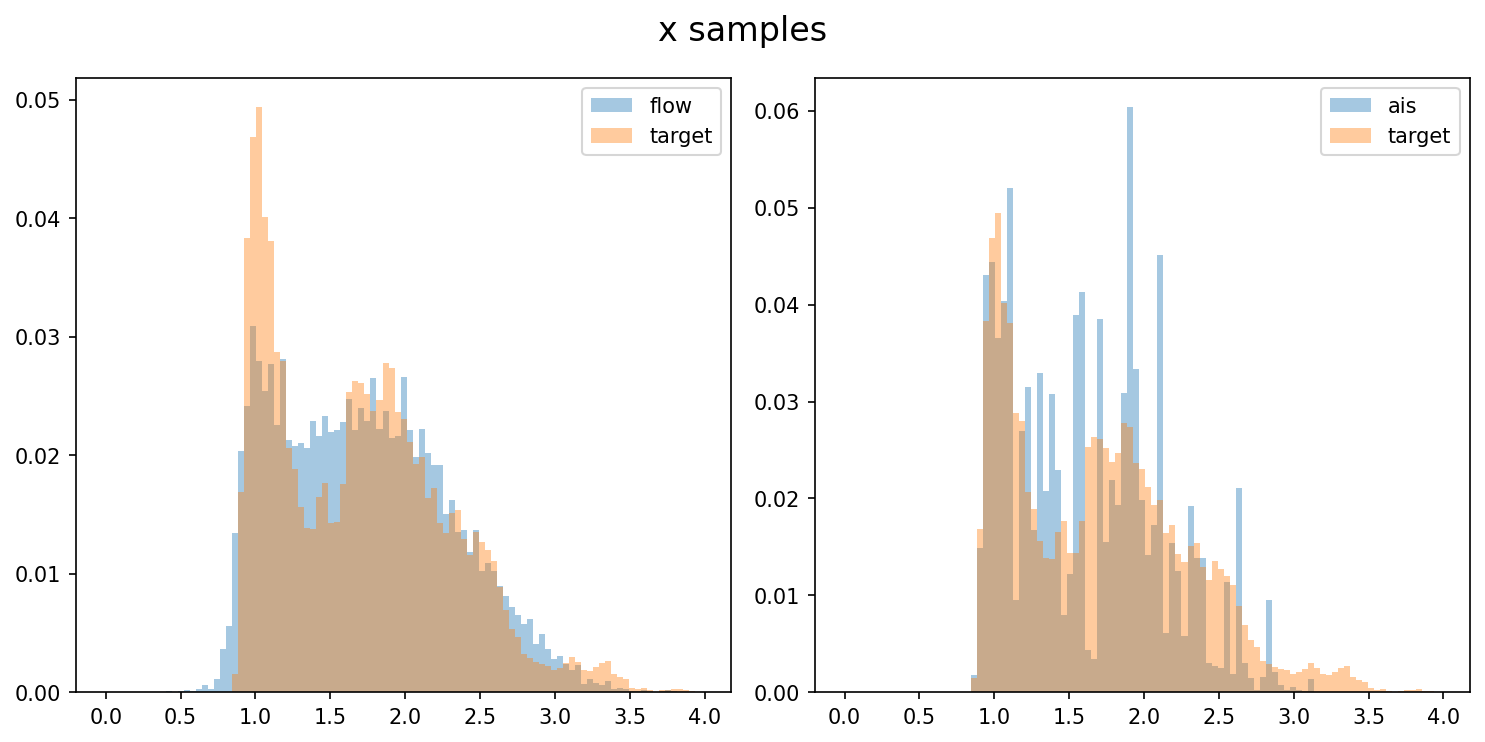

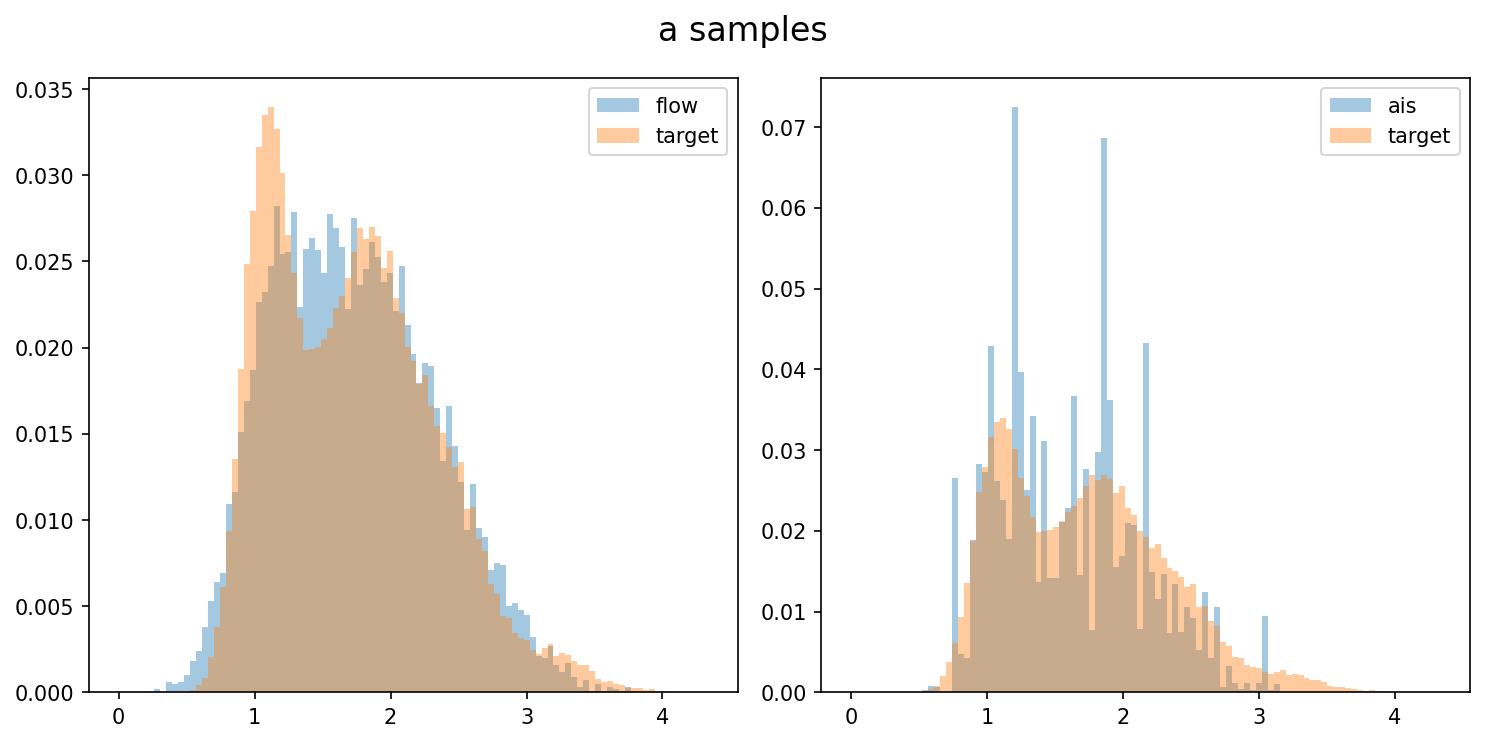

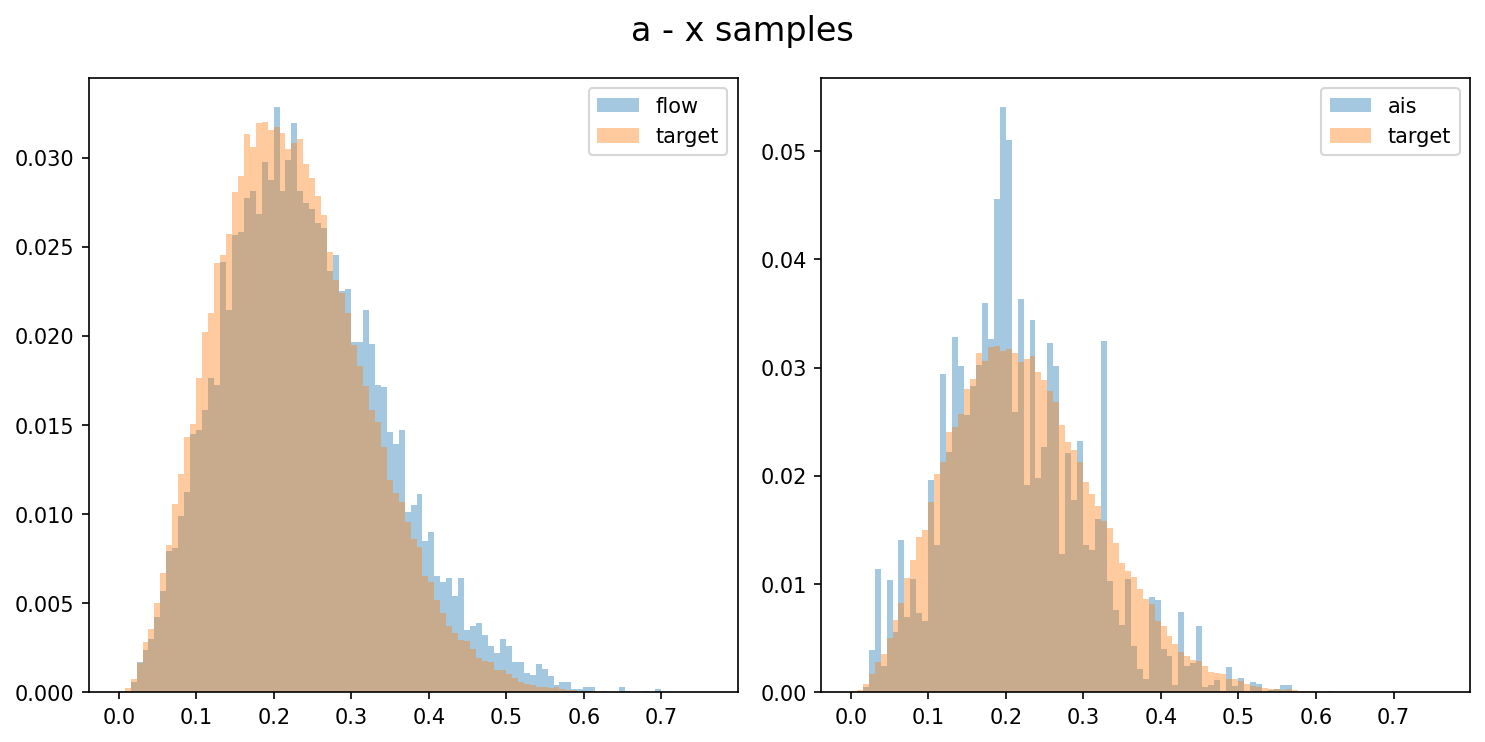

100%|███████████████████████████████████████| 4000/4000 [58:26<00:00,  1.14it/s]


{'ess_marginal': Array(0.10314944, dtype=float32), 'eval_ess_ais': Array(0.00326436, dtype=float32), 'eval_ess_flow': Array(0.00328541, dtype=float32), 'eval_log_lik': Array(-2.8063438, dtype=float32), 'latent_x_mean_abs_centre_of_mass': Array(9.784931e-09, dtype=float32), 'marginal_log_lik': Array(-30.132166, dtype=float32), 'max_abs_diff_log_det_forward_reverse': Array(0.00255203, dtype=float32), 'max_abs_diff_log_prob_after_group_action': Array(0.00136048, dtype=float32), 'mean_abs_diff_log_det_forward_reverse': Array(0.00013753, dtype=float32), 'mean_abs_diff_log_prob_after_group_action': Array(0.00016281, dtype=float32), 'mean_abs_x_centre_of_mass': Array(1.0290714e-08, dtype=float32), 'mean_diff_samples_flow_inverse_forward': Array(9.264255e-07, dtype=float32), 'var_log_w': Array(38.09686, dtype=float32), 'iteration': 3999}


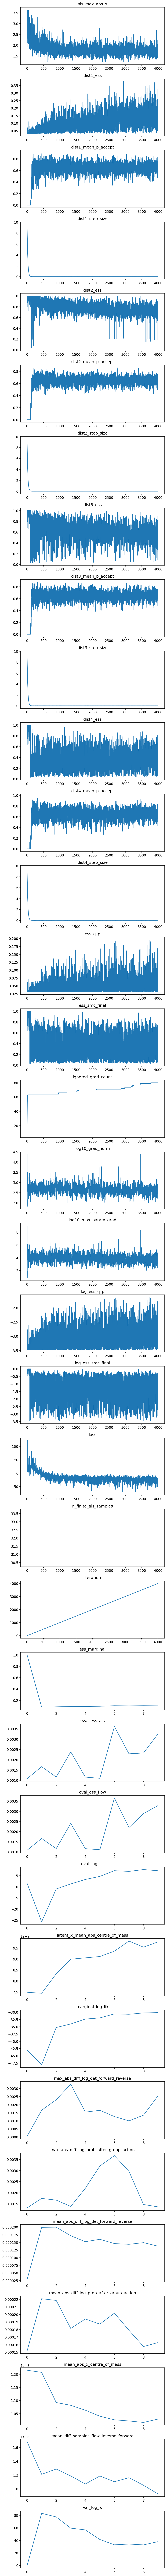

In [14]:
experiment_config = create_train_config(cfg, dim=dim, n_nodes=n_nodes, target_log_p_x_fn=target_log_prob_fn,
                                        load_dataset=load_dataset)

logger, state = train(experiment_config)

# 